# 1. Packages import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import textwrap
import swifter
from pandas_summary import DataFrameSummary
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [2]:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [3]:
import import_ipynb
import utils

importing Jupyter notebook from utils.ipynb


# 2. Data retrieval

In [ ]:
# Asia mapping reference
Asia_mapping=pd.read_excel(r'C:\Users\Eric.Li\OneDrive\Post result data\{0} 2007-2017.xlsx'.format('Asia'),\
                                       sheet_name='Mapping')
Asia_mapping=Asia_mapping.dropna(axis=1,how="all").set_index(Asia_mapping.columns[0])

## 2.1 US data

In [4]:
US_price,abs_return_US,US_index_price,abs_return_index_US=utils.CSV_price('US',2006,2019,False)

In [5]:
US_VWAP,abs_return_VWAP_US,US_index_VWAP,abs_return_VWAP_index_US=utils.CSV_price('US',2006,2019,True)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3214: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [6]:
US_EPS =utils.CSV_EPS("US",2006,2019)

In [7]:
US1=utils.CSV_fundamentals("US",US_price,US_EPS,1,120,0.005,True)

In [8]:
US2=utils.CSV_fundamentals("US",US_price,US_EPS,2,120,0.005,True)

## 2.2 Europe data

In [8]:
Europe_price,abs_return_Europe,Europe_index_price,abs_return_index_Europe=utils.CSV_price('Europe',2006,2019,False)

In [9]:
Europe_VWAP,abs_return_VWAP_Europe,Europe_index_VWAP,abs_return_VWAP_index_Europe=utils.CSV_price('Europe',2006,2019,True)

In [10]:
Europe_EPS =utils.CSV_EPS("Europe",2006,2019)

In [11]:
Europe2=utils.CSV_fundamentals("Europe",Europe_price,Europe_EPS,2,120,0.005,True)

## 2.3 Asia data

In [12]:
Asia_price,abs_return_Asia,Asia_index_price,abs_return_index_Asia=utils.CSV_price('Asia',2006,2019,False)

In [13]:
Asia_VWAP,abs_return_VWAP_Asia,Europe_index_Asia,abs_return_VWAP_index_Asia=utils.CSV_price('Asia',2006,2019,False)

In [14]:
Asia_EPS =utils.CSV_EPS("Asia",2006,2019)

In [15]:
Asia2=utils.CSV_fundamentals("Asia",Asia_price,Asia_EPS,2,120,0.005,True)

# 3. Clean the data for analysis

In [359]:
def data_enhancement(fundamental_df,price_df,index_df,EPS_df,EAR_tuple,post_return_period_list,
                     index_name,MA_period_list,return_lookback_list,range_list,use_cache,region):
    ''' 
    Enhance the existing fundamental data with more independent variaables to run machine learning
    
    *Parameters:
    fundamental_df: refined fundamental_df after CSV_fundamental function
    price_df: pandas dataframe, price data to calculate EAR, mom
    index_df: dataframe with market index data and exogeneous variables
    EPS_df: pandas dataframe, consensus EPS data to calculate revision
    EAR_tuple: (start_reference,number of days), e.g. (0,1) means day1 return
    post_return_period_list: list of periods used to calculate post return
    index_name:dict with keys -"index","yield_long","yield_short","inflation","currency","VIX"
    MA_period_list: list for periods used to calculate moving average deviation
    return_lookback_list:list for periods used to calculate past return abs
    range_list:list for periods used to calculate the chart position
    use_cache: boolean, if true then look for the exported csv
    region: hard coded region for export use
    
    *Dependent variable:
    post_return_net: relative return after EAR period for a list of periods
    success: if relative return is positive
    
    *Independent variables:
    adj_quarter: Q1 to Q4, string
    Q1-Q4: dummy variable 
    Year: 2010-2017, string
    2010-2017: dummy variable
    Month: Jan to Dec string
    Jan to Dec: dummy variable
    Day: early mid or late, string
    Early mid late: day dummy
    Supersector dummy: dummy transformation from Supersector
    
    EAR_net: 3 day relative return centered the earning day, float
    EAR_net_dummy: 1 if EAR_net above zero
    EAR_net_last: EAR_net in the previous quarter
    EAR_net_last_dummy: 1 if EAR_net_last above zero
    
    Revision_real: 2 day earning revision, overwrite any abosolute value above 90% to 90%
    Revision_dummy: 1 if Revision real is positive
    pre_revision: revision for last 40 business days
    pre_EPS_avg: average EPS for the last 40 business days
    
    Market cap: log market cap value in US dollars
    mom/mom_short: log absolute stock return for last 52 weeks and last 4 weeks, up to the start of EAR period
    
    beta: market beta for 260 business days up to before the EAR period
    
    macro variables: value in yield,inflation,currency,VIX on the earning day
    commodity variables: value in gold,oil,bloomberg commodity index on the earning day
    
    momentum index: long and short,deviation from MA and past return on the end of EAR period
    market index: deviation from MA and past return on the end of EAR period
    stock technicals: deviation n from MA, and chart position on the end of EAR period
    
    date_timestamp: transform to pandas timestamp so that we can sort
    
    '''

    if use_cache is True:
        try:
            data=pd.read_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))
            new_index=pd.MultiIndex.from_tuples(list(zip(data.iloc[:,0],data.iloc[:,1],data.iloc[:,2],data.iloc[:,3])))
            data.index=new_index
            fundamental_df=data.iloc[:,4:]
        except:
            print("No such file!")
            
    else:

        #placing here
        data=pd.read_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))
        new_index=pd.MultiIndex.from_tuples(list(zip(data.iloc[:,0],data.iloc[:,1],data.iloc[:,2],data.iloc[:,3])))
        data.index=new_index
        fundamental_df=data.iloc[:,4:]
            
        #Target rel index used for return calculation
        index_series=index_df.loc[index_name["index"]]
        
        #Add next earning date as a separate column
        fundamental_df["Next date"]=fundamental_df.apply(lambda x:x.name[2],axis=1)
        
        #Dependent variable
        for i in post_return_period_list:
            fundamental_df["post_return_net_{0}".format(i)]=fundamental_df.swifter.\
            apply(lambda x:utils.return_calc_log(x.name[0],x.name[1],price_df,index_series,(EAR_tuple[0]+EAR_tuple[1],i),'rel')\
                  ,axis=1)    
            
            fundamental_df["result_net_{0}".format(i)]=(fundamental_df["post_return_net_{0}".format(i)]>0)*1.0

            fundamental_df["post_return_net_{0}_last".format(i)]=fundamental_df.swifter.\
            apply(lambda x: fundamental_df.loc[x.name[0]].xs(x.name[1],level=1)["post_return_net_{0}".format(i)].iloc[0]\
                            if x.name[1] in list(fundamental_df.loc[x.name[0]]["Next date"]) else None,axis=1)    

            fundamental_df["result_net_{0}_last".format(i)]=(fundamental_df["post_return_net_{0}_last".format(i)]>0)*1.0

        fundamental_df.to_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))
        


        

        def quarter(month):
            '''
            month: three letter string
            '''
            if month in ["Jan","Feb","Mar"]:
                return "Q1"
            elif month in ["Apr","May",'Jun']:
                return "Q2"
            elif month in ["Jul","Aug","Sep"]:
                return "Q3"
            else:
                return "Q4"

        fundamental_df["adj_quarter"]=fundamental_df.swifter.apply(lambda x:quarter(x.name[1][3:6]),axis=1)

        fundamental_df["Year"]=fundamental_df.swifter.apply(lambda x: x.name[1][-4:],axis=1)

        fundamental_df["Month"]=fundamental_df.swifter.apply(lambda x:x.name[1][3:6],axis=1)


        def day_in_month(day):
            ''' 
            day: int
            '''
            if day<=10:
                return "Early"
            elif day<=20:
                return "Mid"
            else:
                return "Late"

        fundamental_df["Day"]=fundamental_df.swifter.apply(lambda x:day_in_month(int(x.name[1][:2])),axis=1)                         

        # Dummy variable 
        for i in fundamental_df["Supersector"].dropna().unique():
            fundamental_df[i]=(fundamental_df["Supersector"]==i)*1.0

        for i in fundamental_df["adj_quarter"].dropna().unique():
            fundamental_df[i]=(fundamental_df["adj_quarter"]==i)*1.0    

        for i in fundamental_df["Year"].dropna().unique():
            fundamental_df[i]=(fundamental_df["Year"]==i)*1.0  

        for i in fundamental_df["Month"].dropna().unique():
            fundamental_df[i]=(fundamental_df["Month"]==i)*1.0  

        for i in fundamental_df["Day"].dropna().unique():
            fundamental_df[i]=(fundamental_df["Day"]==i)*1.0          
        
        
        # EAR variable 
        fundamental_df["EAR_net"]=fundamental_df.swifter.apply(lambda x:utils.return_calc_log(x.name[0],x.name[1],\
                                                                                                         price_df,index_series,\
                                                                                       EAR_tuple,'rel'),axis=1)
        
        fundamental_df["EAR_net_dummy"]=(fundamental_df["EAR_net"]>0)*1.0
        
        
        fundamental_df["EAR_net_last"]=fundamental_df.swifter.apply(lambda x: fundamental_df.loc[x.name[0]].\
                                                                    xs(x.name[1],level=1)["EAR_net"].iloc[0]\
                        if x.name[1] in list(fundamental_df.loc[x.name[0]]["Next date"]) else None,axis=1)
        
        fundamental_df["EAR_net_last_dummy"]=(fundamental_df["EAR_net_last"]>0)*1.0
        
        fundamental_df.to_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))

        #adjust reivision number
        fundamental_df["post_revision"]=fundamental_df["Revision_real"]
        
        fundamental_df.loc[fundamental_df["post_revision"]>=0.9,"post_revision"]=0.9
        fundamental_df.loc[fundamental_df["post_revision"]<=-0.9,"post_revision"]=-0.9

        fundamental_df["post_revision_dummy"]=(fundamental_df["post_revision"]>0)*1.0

        fundamental_df["post_revision_last"]=fundamental_df.swifter.apply(lambda x: fundamental_df.loc[x.name[0]].\
                                                                          xs(x.name[1],level=1)["post_revision"].iloc[0]\
                        if x.name[1] in list(fundamental_df.loc[x.name[0]]["Next date"]) else None,axis=1)
        
        fundamental_df["post_revision_last_dummy"]=(fundamental_df["post_revision_last"]>0)*1.0        
        
        fundamental_df["pre_revision"]=fundamental_df.swifter.apply(lambda x: \
                                                                    utils.revision_calc(x.name[0],x.name[1],EPS_df,\
                                                                                        (-41,40)),axis=1)
        
        fundamental_df["pre_EPS_avg"]=fundamental_df.swifter.apply(lambda x: utils.EPS_avg(x.name[0],x.name[1],EPS_df,(-41,40))\
                                                               ,axis=1)

        fundamental_df.loc[fundamental_df["pre_revision"]>=0.9,"pre_revision"]=0.9
        fundamental_df.loc[fundamental_df["pre_revision"]<=-0.9,"pre_revision"]=-0.9     
        
        fundamental_df["pre_revision_dummy"]=(fundamental_df["pre_revision"]>0)*1.0
        
        fundamental_df.to_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))
        
        # Market cap
        
        fundamental_df["Market cap"]=np.log(fundamental_df["Market cap"])
        
        fundamental_df.to_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))
        
        # Stock momentum up to the start of EAR period
        fundamental_df["stock_mom"]=fundamental_df.swifter.apply(lambda x:utils.return_calc_log(x.name[0],x.name[1],price_df,\
                                                                                          index_series,\
                                                                                       (-280+EAR_tuple[0],260),'abs'),axis=1)
        
        fundamental_df["stock_mom_short"]=fundamental_df.swifter.apply(lambda x:utils.\
                                                                 return_calc_log(x.name[0],x.name[1],price_df,\
                                                                                 index_series,(-20+EAR_tuple[0],20),'abs'),axis=1)
        
        fundamental_df.to_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))
        
        #beta
        abs_return_df=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
        
        index_return_series=index_series/index_series.shift(1)-1
        
        fundamental_df["beta"]=fundamental_df.swifter.apply(lambda x:\
                                                    utils.calc_beta(x.name[0],x.name[1],abs_return_df,\
                                                              index_return_series,260,EAR_tuple[0]),axis=1)
        
        fundamental_df.to_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))
        
        # macro variables
        fundamental_df["yield_long"]=fundamental_df.swifter.\
        apply(lambda x:index_df.loc[index_name["yield_long"],x.name[1]],axis=1)

        fundamental_df["yield_short"]=fundamental_df.swifter.\
        apply(lambda x:index_df.loc[index_name["yield_short"],x.name[1]],axis=1)

        fundamental_df["yield_slope"]=fundamental_df["yield_long"]-fundamental_df["yield_short"]

        fundamental_df["inflation"]=fundamental_df.swifter.\
        apply(lambda x:index_df.loc[index_name["inflation"],x.name[1]],axis=1)

        fundamental_df["currency"]=fundamental_df.swifter.\
        apply(lambda x:index_df.loc[index_name["currency"],x.name[1]],axis=1)

        fundamental_df["vix"]=fundamental_df.swifter.\
        apply(lambda x:index_df.loc[index_name["vix"],x.name[1]],axis=1)
        
        # commodity    
        fundamental_df["gold"]=fundamental_df.swifter.\
        apply(lambda x:index_df.loc["GOLDS Comdty",x.name[1]],axis=1)        
        
        fundamental_df["oil"]=fundamental_df.swifter.\
        apply(lambda x:index_df.loc["Cl1 Comdty",x.name[1]],axis=1) 
        
        fundamental_df["commodity"]=fundamental_df.swifter.\
        apply(lambda x:index_df.loc["BWMING Index",x.name[1]],axis=1)
        
        fundamental_df.to_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))
        
        #momentum index
        for s in MA_period_list: #calculate the MA on the end of EAR period
            fundamental_df["momentum_long_MA_{0}".format(s)]=fundamental_df.swifter.\
            apply(lambda x:utils.MA_deviation(index_name["momentum_long"],x.name[1],index_df,s,EAR_tuple[0]+EAR_tuple[1]-1),axis=1)

            fundamental_df["momentum_short_MA_{0}".format(s)]=fundamental_df.swifter.\
            apply(lambda x:utils.MA_deviation(index_name["momentum_short"],x.name[1],index_df,s,EAR_tuple[0]+EAR_tuple[1]-1),axis=1)
        
        fundamental_df.to_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))
        
        for s in return_lookback_list:#calculate the return up to the end of EAR Period
            fundamental_df["momentum_long_return_{0}".format(s)]=fundamental_df.swifter.\
            apply(lambda x:utils.return_calc_log(index_name["momentum_long"],\
                                       x.name[1],index_df,index_df,(-s+EAR_tuple[0]+EAR_tuple[1]-1,\
                                                                    EAR_tuple[0]+EAR_tuple[1]-1),"abs"),axis=1)
            
            fundamental_df["momentum_short_return_{0}".format(s)]=fundamental_df.swifter.\
            apply(lambda x:utils.return_calc_log(index_name["momentum_short"],\
                                       x.name[1],index_df,index_df,(-s+EAR_tuple[0]+EAR_tuple[1]-1,\
                                                                    EAR_tuple[0]+EAR_tuple[1]-1),"abs"),axis=1)
        
        # market
        for s in MA_period_list:#calculate the MA on the end of EAR period
            fundamental_df["market_MA_{0}".format(s)]=fundamental_df.swifter.\
            apply(lambda x:utils.MA_deviation(index_name["index"],x.name[1],index_df,s,EAR_tuple[0]+EAR_tuple[1]-1),axis=1)
        
        fundamental_df.to_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))
        
        for s in return_lookback_list:#calculate the return up to the end of EAR Period
            fundamental_df["market_return_{0}".format(s)]=fundamental_df.swifter.\
            apply(lambda x:utils.return_calc_log(index_name["index"],\
                                       x.name[1],index_df,index_df,(-s+EAR_tuple[0]+EAR_tuple[1]-1,\
                                                                    EAR_tuple[0]+EAR_tuple[1]-1),"abs"),axis=1)        
            
        # stock
        for s in MA_period_list:#calculate the MA on the end of EAR period
            fundamental_df["stock_MA_n_{0}".format(s)]=fundamental_df.swifter.\
            apply(lambda x:utils.MA_n_deviation(x.name[0],x.name[1],price_df,s,EAR_tuple[0]+EAR_tuple[1]-1,x["30d_vol"]),axis=1)
        
        fundamental_df.to_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))
        
        
        for s in range_list:#calculate the range to the end of EAR Period
            fundamental_df["stock_chart_position_{0}".format(s)]=fundamental_df.swifter.\
            apply(lambda x:utils.chart_position(x.name[0],x.name[1],price_df,s,EAR_tuple[0]+EAR_tuple[1]-1),axis=1) 

        fundamental_df.to_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))
        
        
        # Timestamp
        fundamental_df["Date_timstamp"]=fundamental_df.apply(lambda x:pd.Timestamp(x["Date"]),axis=1)
        fundamental_df["year_quarter"]=fundamental_df.apply(lambda x:str(x["Year"])+x["adj_quarter"],axis=1)
        fundamental_df.to_csv(r'C:\Users\Eric.Li\OneDrive\Post result data cache\{0}_reg_data.csv'.format(region))
    return fundamental_df
    

In [10]:
target_US=data_enhancement(US1.copy(),US_price,US_index_price,US_EPS,(0,1),[5,10,20,30],
                           {"index": "SPX Index","yield_long":"USGG10YR Index","yield_short":"USGG3M Index",
                           "inflation":"CPI INDX Index","currency":"DXY Index","vix":"VIX Index",
                           "momentum_long":"MSZZMOMO Index","momentum_short":"MSZZ3MMO Index"},[50,150],[120],[120],
                           True,"US")

In [11]:
sorted_target_US=target_US.sort_values("Date_timstamp")

## Manual cluster and feature selection

In [12]:
sorted_target_US_v1=sorted_target_US[(sorted_target_US["EAR_net"]>0) & (sorted_target_US["post_revision"]>0)]
sorted_target_US_v2=sorted_target_US[(sorted_target_US["EAR_net"]>0) & (sorted_target_US["post_revision"]<0)]
sorted_target_US_v3=sorted_target_US[(sorted_target_US["EAR_net"]<0) & (sorted_target_US["post_revision"]>0)]
sorted_target_US_v4=sorted_target_US[(sorted_target_US["EAR_net"]<0) & (sorted_target_US["post_revision"]<0)]

In [457]:
dependent_variable_5d="result_net_5"
features_5d=["Market cap",'post_return_net_5_last',"post_revision","pre_revision","stock_mom","stock_mom_short","beta","30d_vol",\
          "EAR_net","EAR_net_last","yield_slope","currency","vix","gold","oil","commodity","pre_EPS_avg",\
         "momentum_long_MA_150","market_MA_50","stock_MA_n_150"]


In [458]:
X_5d=sorted_target_US[features_5d].dropna(how="any",axis=0)
y_5d=sorted_target_US[dependent_variable_5d].loc[X_5d.index]
X_v1_5d=sorted_target_US_v1[features_5d].dropna(how="any",axis=0)
y_v1_5d=sorted_target_US_v1[dependent_variable_5d].loc[X_v1_5d.index]
X_v2_5d=sorted_target_US_v2[features_5d].dropna(how="any",axis=0)
y_v2_5d=sorted_target_US_v2[dependent_variable_5d].loc[X_v2_5d.index]
X_v3_5d=sorted_target_US_v3[features_5d].dropna(how="any",axis=0)
y_v3_5d=sorted_target_US_v3[dependent_variable_5d].loc[X_v3_5d.index]
X_v4_5d=sorted_target_US_v4[features_5d].dropna(how="any",axis=0)
y_v4_5d=sorted_target_US_v4[dependent_variable_5d].loc[X_v4_5d.index]
X_v13_5d=sorted_target_US_v13[features_5d].dropna(how="any",axis=0)
y_v13_5d=sorted_target_US_v13[dependent_variable_5d].loc[X_v13_5d.index]

In [459]:
dependent_variable_10d="result_net_10"
features_10d=["Market cap",'post_return_net_10_last',"post_revision","pre_revision","stock_mom","stock_mom_short","beta","30d_vol",\
          "EAR_net","EAR_net_last","yield_slope","currency","vix","gold","oil","commodity","pre_EPS_avg",\
         "momentum_long_MA_150","market_MA_50","stock_MA_n_150"]


In [460]:
X_10d=sorted_target_US[features_10d].dropna(how="any",axis=0)
y_10d=sorted_target_US[dependent_variable_10d].loc[X_10d.index]
X_v1_10d=sorted_target_US_v1[features_10d].dropna(how="any",axis=0)
y_v1_10d=sorted_target_US_v1[dependent_variable_10d].loc[X_v1_10d.index]
X_v2_10d=sorted_target_US_v2[features_10d].dropna(how="any",axis=0)
y_v2_10d=sorted_target_US_v2[dependent_variable_10d].loc[X_v2_10d.index]
X_v3_10d=sorted_target_US_v3[features_10d].dropna(how="any",axis=0)
y_v3_10d=sorted_target_US_v3[dependent_variable_10d].loc[X_v3_10d.index]
X_v4_10d=sorted_target_US_v4[features_10d].dropna(how="any",axis=0)
y_v4_10d=sorted_target_US_v4[dependent_variable_10d].loc[X_v4_10d.index]
X_v13_10d=sorted_target_US_v13[features_10d].dropna(how="any",axis=0)
y_v13_10d=sorted_target_US_v13[dependent_variable_10d].loc[X_v13_10d.index]

In [461]:
dependent_variable_20d="result_net_20"
features_20d=["Market cap",'post_return_net_20_last',"post_revision","post_revision_last","pre_revision","pre_EPS_avg"
              ,"stock_mom","stock_mom_short","beta","30d_vol","EAR_net","EAR_net_last","yield_slope","vix","gold",
              "oil","momentum_long_MA_150","market_MA_50","stock_MA_n_150"]


In [462]:
X_20d=sorted_target_US[features_20d].dropna(how="any",axis=0)
y_20d=sorted_target_US[dependent_variable_20d].loc[X_20d.index]
X_v1_20d=sorted_target_US_v1[features_20d].dropna(how="any",axis=0)
y_v1_20d=sorted_target_US_v1[dependent_variable_20d].loc[X_v1_20d.index]
X_v2_20d=sorted_target_US_v2[features_20d].dropna(how="any",axis=0)
y_v2_20d=sorted_target_US_v2[dependent_variable_20d].loc[X_v2_20d.index]
X_v3_20d=sorted_target_US_v3[features_20d].dropna(how="any",axis=0)
y_v3_20d=sorted_target_US_v3[dependent_variable_20d].loc[X_v3_20d.index]
X_v4_20d=sorted_target_US_v4[features_20d].dropna(how="any",axis=0)
y_v4_20d=sorted_target_US_v4[dependent_variable_20d].loc[X_v4_20d.index]

In [463]:
dependent_variable_30d="result_net_30"
features_30d=["Market cap",'post_return_net_30_last',"post_revision","pre_revision","stock_mom","stock_mom_short","beta","30d_vol",\
          "EAR_net","EAR_net_last","yield_slope","currency","vix","gold","oil","commodity","pre_EPS_avg",\
         "momentum_long_MA_150","market_MA_50","stock_MA_n_150"]


In [464]:
X_30d=sorted_target_US[features_30d].dropna(how="any",axis=0)
y_30d=sorted_target_US[dependent_variable_30d].loc[X_30d.index]

In [465]:
X_v1_30d=sorted_target_US_v1[features_30d].dropna(how="any",axis=0)
y_v1_30d=sorted_target_US_v1[dependent_variable_30d].loc[X_v1_30d.index]
X_v2_30d=sorted_target_US_v2[features_30d].dropna(how="any",axis=0)
y_v2_30d=sorted_target_US_v2[dependent_variable_30d].loc[X_v2_30d.index]
X_v3_30d=sorted_target_US_v3[features_30d].dropna(how="any",axis=0)
y_v3_30d=sorted_target_US_v3[dependent_variable_30d].loc[X_v3_30d.index]
X_v4_30d=sorted_target_US_v4[features_30d].dropna(how="any",axis=0)
y_v4_30d=sorted_target_US_v4[dependent_variable_30d].loc[X_v4_30d.index]
X_v13_30d=sorted_target_US_v13[features_30d].dropna(how="any",axis=0)
y_v13_30d=sorted_target_US_v13[dependent_variable_30d].loc[X_v13_30d.index]

In [442]:
clf=RandomForestClassifier(n_estimators=100,max_depth=10)


In [450]:
y=y_v1_10d
X=X_v1_10d

In [451]:
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [452]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

beta                       0.064284
yield_slope                0.062724
30d_vol                    0.059443
stock_mom                  0.055357
vix                        0.054320
post_return_net_10_last    0.052546
pre_revision               0.051218
post_revision              0.050482
momentum_long_MA_150       0.049532
commodity                  0.048252
Market cap                 0.046912
stock_mom_short            0.046530
stock_MA_n_150             0.045868
currency                   0.045395
EAR_net_last               0.045382
oil                        0.045376
market_MA_50               0.044860
EAR_net                    0.044438
pre_EPS_avg                0.044363
gold                       0.042718
dtype: float64

ROC AUC 0.8717184209100778


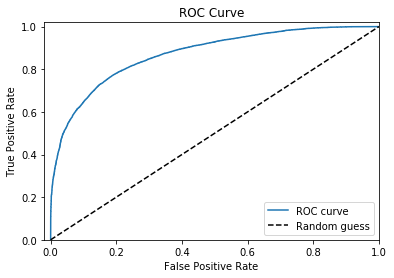

In [453]:

print("ROC AUC",roc_auc_score(y, clf.predict_proba(X)[:,1]))

fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:,1])
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

## Random forest by quarters

In [298]:
def rolling_RF_df(sorted_X,sorted_y,return_df,bins,train_bins,n_estimators,max_depth,boundary,long):
    '''
    results from a specific random forest model
    '''
    
    RF_summary=pd.DataFrame(index=range(train_bins,bins),columns=["hit","count","return_avg","return_vol"])
    RF_detailed=pd.DataFrame()
    
    for i in range(train_bins,bins):
        X_train=sorted_X.iloc[round(sorted_X.shape[0]*(i-train_bins)/bins):round(sorted_X.shape[0]*(i)/bins)]
        X_test=sorted_X.iloc[round(sorted_X.shape[0]*(i)/bins):round(sorted_X.shape[0]*(i+1)/bins)]
        y_train=sorted_y.iloc[round(sorted_y.shape[0]*(i-train_bins)/bins):round(sorted_y.shape[0]*(i)/bins)]
        y_test=sorted_y.iloc[round(sorted_y.shape[0]*(i)/bins):round(sorted_y.shape[0]*(i+1)/bins)]
        if long:
            y_train=y_train
            y_test=y_test
        else:
            y_train=1-y_train
            y_test=1-y_test
            
        clf=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,random_state=10)
        clf.fit(X_train,y_train)
        
        confusion=confusion_matrix(y_test,clf.predict_proba(X_test)[:,1]>boundary)
        pred=(clf.predict_proba(X_test)[:,1]>boundary)*1.0
        
        if long:
            RF_summary.loc[i]=[confusion[:,1][-1]/confusion[:,1].sum(),confusion[:,1].sum(),(pred*return_df.loc[y_test.index]).\
                          mean(),(pred*return_df.loc[y_test.index]).std()]
        else:
            RF_summary.loc[i]=[confusion[:,1][-1]/confusion[:,1].sum(),confusion[:,1].sum(),(pred*return_df.loc[y_test.index]*-1)\
                          .mean(),(pred*return_df.loc[y_test.index]*-1).std()]

        target_RF_detailed=y_test.to_frame()
        target_RF_detailed.columns=["actual"]
        if long:
            target_RF_detailed["return"]=return_df.loc[target_RF_detailed.index]
        else:
            target_RF_detailed["return"]=return_df.loc[target_RF_detailed.index]*-1
        target_RF_detailed["pred"]=(clf.predict_proba(X_test)[:,1]>boundary)*1
        target_RF_detailed["pred_prob"]=clf.predict_proba(X_test)[:,1]
        target_RF_detailed["year"]=target_RF_detailed.apply(lambda x:x.name[1][-4:],axis=1)
        RF_detailed=pd.concat([RF_detailed,target_RF_detailed],axis=0)
                    
    
    return RF_summary,RF_detailed

In [20]:
def rolling_RF_cv(sorted_X,sorted_y,return_df,bin_list,train_bin_list,estimator_list,depth_list,boundary_list,long):
    '''
    iterate all the different available hyperparameter choice for random forest
    '''
    
    RF_dict={}
    RF_dict_metrics={}
    RF_pred_dict={}
    for a in bin_list:
        for b in train_bin_list:
            for c in estimator_list:
                for d in depth_list:
                    for e in boundary_list:
                        target_df,target_pred=rolling_RF_df(sorted_X,sorted_y,return_df,a,b,c,d,e,long)
                        RF_dict[(a,b,c,d,e)]=target_df
                        RF_pred_dict[(a,b,c,d,e)]=target_pred
                        RF_dict_metrics[(a,b,c,d,e)]=[target_df["hit"].mean(),
                                                      (target_df["hit"].mean()-0.5)/target_df["hit"].std(),
                                                     target_df["count"].mean(),target_df["return_avg"].mean(),
                                                     target_df["return_avg"].mean()/target_df["return_avg"].std()]
                        
    return RF_dict,RF_dict_metrics,RF_pred_dict
                    
    

### Short iterate

In [467]:
RF_dict_v1_5d_s,RF_dict_metrics_v1_5d_s,RF_pred_dict_v1_5d_s=rolling_RF_cv(X_v4_5d,y_v4_5d,\
                                                                        sorted_target_US["post_return_net_5"],[41],\
                                                      [1,2,3,4],[50,100,200],[5,10,15],[0.55,0.6],False)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

In [468]:
RF_dict_v1_10d_s,RF_dict_metrics_v1_10d_s,RF_pred_dict_v1_10d_s=rolling_RF_cv(X_v4_10d,y_v4_10d,\
                                                                        sorted_target_US["post_return_net_10"],[41],\
                                                      [1,2,3,4],[50,100,200],[5,10,15],[0.55,0.6],False)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

In [469]:
RF_dict_v1_20d_s,RF_dict_metrics_v1_20d_s,RF_pred_dict_v1_20d_s=rolling_RF_cv(X_v4_20d,y_v4_20d,\
                                                                        sorted_target_US["post_return_net_20"],[41],\
                                                      [1,2,3,4],[50,100,200],[5,10,15],[0.55,0.6],False)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

In [470]:
RF_dict_v1_30d_s,RF_dict_metrics_v1_30d_s,RF_pred_dict_v1_30d_s=rolling_RF_cv(X_v4_30d,y_v4_30d,\
                                                                        sorted_target_US["post_return_net_30"],[41],\
                                                      [1,2,3,4],[50,100,200],[5,10,15],[0.55,0.6],False)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

In [290]:
pd.DataFrame(RF_dict_metrics_v1_20d_s).T.sort_values(1)

0         1           2         3         4
41 3 100 10 0.60  0.495461 -0.031623   78.473684 -0.002147 -0.432227
   1 100 15 0.60  0.516159  0.121373   87.575000 -0.002014 -0.399082
         10 0.55  0.513990  0.136532  157.150000 -0.002893 -0.404326
         15 0.55  0.514685  0.155704  154.675000 -0.002802 -0.414108
     200 15 0.55  0.516758  0.186270  154.475000 -0.003033 -0.485196
   3 100 10 0.55  0.521861  0.209284  152.947368 -0.003126 -0.415773
   1 100 5  0.55  0.522023  0.212643  157.050000 -0.003425 -0.463274
         10 0.60  0.530292  0.212994   89.525000 -0.002177 -0.434662
         5  0.60  0.545107  0.221780   87.100000 -0.002356 -0.419358
     200 5  0.55  0.528934  0.227173  154.625000 -0.003140 -0.414422
   3 200 10 0.55  0.524097  0.237119  147.052632 -0.003474 -0.478540
   1 200 10 0.55  0.526895  0.238432  155.150000 -0.003039 -0.433735
   3 200 5  0.55  0.538456  0.258119  132.289474 -0.003262 -0.436286
   1 200 15 0.60  0.543915  0.295293   84.600000 -0.002176 -0.473247
   3 200 5  0.60  0.576002  0.327814   58.157895 -0.002264 -0.408730
         15 0.55  0.532636  0.341388  152.894737 -0.003651 -0.521735
         10 0.60  0.544757  0.347798   71.105263 -0.002672 -0.507458
     100 15 0.55  0.531560  0.374938  157.763158 -0.003375 -0.494006
            0.60  0.553410  0.383712   83.605263 -0.002379 -0.474394
     200 15 0.60  0.546436  0.389394   76.105263 -0.002510 -0.511557
   1 200 5  0.60  0.580718  0.403799   83.625000 -0.002322 -0.431735
   3 100 5  0.60  0.598006  0.434356   59.947368 -0.002303 -0.420637
   1 200 10 0.60  0.558971  0.468616   86.425000 -0.002210 -0.454594
   3 100 5  0.55  0.555418  0.519520  136.815789 -0.003516 -0.447584

In [299]:
a_RF,b_RF=rolling_RF_df(X_v4_20d,y_v4_20d,sorted_target_US["post_return_net_20"],41,3,200,5,0.55,False)

In [302]:
a_RF

hit count   return_avg  return_vol
3        0.5    54   0.00117417   0.0857694
4   0.486364   220 -0.000690939   0.0707616
5   0.580508   236   0.00436909   0.0438448
6      0.275    40  -0.00151004   0.0124032
7   0.460396   202  -0.00220747   0.0587623
8        0.6    20  0.000959669   0.0351163
9   0.721429   140    0.0207541   0.0740087
10       0.5     6  0.000479137   0.0114087
11  0.714286    14   0.00124392   0.0162397
12   0.52231   381    0.0083166    0.092697
13    0.4375   160  -0.00247953   0.0371299
14  0.645161    62   0.00252169    0.031407
15  0.449198   187  -0.00272558   0.0379875
16     0.375    16 -0.000269029  0.00800818
17  0.592593    54  0.000917858   0.0233185
18  0.554264   258   0.00509767   0.0421649
19  0.551237   283   0.00135319    0.046596
20  0.454106   207  -0.00134414   0.0374139
21  0.571429    21  0.000414008  0.00962302
22  0.666667     3  0.000470201  0.00999332
23  0.533333    15  0.000859085   0.0159384
24       0.6    15   0.00103879   0.0196703
25  0.566667    30    0.0017817    0.031732
26       0.5    10  5.99436e-05   0.0109966
27       0.5    42   0.00122646   0.0285548
28  0.555556    27 -1.06235e-05   0.0133191
29         1     1  0.000142313  0.00322332
30  0.679144   187     0.011857   0.0597187
31  0.663594   434    0.0225283   0.0788392
32  0.528067   481   0.00432649   0.0708519
33  0.571429    35  0.000394726   0.0193003
34  0.461538    52 -3.06783e-05   0.0186693
35  0.434783    46 -0.000175422    0.017571
36      0.48    25 -0.000250246   0.0337581
37         0     1 -0.000140241  0.00317329
38  0.607843   204    0.0158648   0.0661648
39  0.639344   427    0.0309173   0.0986261
40  0.482599   431  -0.00326117    0.106969

In [295]:
(b_RF["pred"]*b_RF["return"]).dropna().sort_values().mean()

0.0032760485840338427

In [256]:
pd.DataFrame(RF_dict_metrics_v1_10d_s).T.sort_values(3)

0         1           2         3         4
21 2 200 10 0.55  0.526105  0.422339  230.684211 -0.000988 -0.351201
   3 200 10 0.60  0.646721  0.678524   86.944444 -0.000984 -0.367737
         5  0.55  0.471764 -0.118159  153.611111 -0.000960 -0.358147
   2 100 5  0.55  0.462149 -0.209447  208.578947 -0.000960 -0.359838
41 3 200 15 0.55  0.524832  0.303125  123.157895 -0.000953 -0.322579
21 3 100 10 0.55  0.515395  0.272938  208.833333 -0.000932 -0.374748
     200 5  0.60  0.640745  0.435194   65.333333 -0.000930 -0.306973
41 3 200 10 0.55  0.529732  0.335534  115.657895 -0.000922 -0.301326
21 3 200 20 0.55  0.513488  0.201332  218.333333 -0.000911 -0.362227
41 3 200 20 0.55  0.535479  0.293051  126.052632 -0.000909 -0.255876
21 3 100 5  0.60  0.616505  0.365919   78.944444 -0.000907 -0.313859
     200 10 0.55  0.506764  0.124650  193.000000 -0.000903 -0.355211
   2 100 20 0.55  0.516142  0.245483  254.631579 -0.000898 -0.336336
     200 15 0.55  0.511999  0.180334  232.947368 -0.000897 -0.356969
   3 100 5  0.55  0.506580  0.084157  158.666667 -0.000897 -0.316576
   2 200 5  0.55  0.469363 -0.294300  192.210526 -0.000893 -0.312181
   4 200 15 0.55  0.532552  0.504191  191.764706 -0.000867 -0.326864
     100 5  0.55  0.482849 -0.115403  128.588235 -0.000862 -0.351482
   1 200 5  0.60  0.525848  0.119536   92.250000 -0.000857 -0.349741
41 4 200 20 0.55  0.528952  0.363473  130.729730 -0.000854 -0.232839
21 2 100 10 0.55  0.517352  0.292208  247.473684 -0.000850 -0.340766
   3 100 10 0.60  0.550732  0.356975  101.111111 -0.000843 -0.315977
   2 200 20 0.55  0.506476  0.109297  241.105263 -0.000835 -0.335358
41 3 100 15 0.55  0.518160  0.236639  134.578947 -0.000830 -0.284042
   2 200 10 0.55  0.504764  0.037058  122.615385 -0.000819 -0.264786
21 3 200 15 0.60  0.465517 -0.216563   89.555556 -0.000816 -0.288571
41 2 200 20 0.55  0.497027 -0.029465  124.435897 -0.000814 -0.240134
   3 100 10 0.55  0.487394 -0.097092  122.921053 -0.000795 -0.270834
21 1 200 5  0.55  0.529969  0.255374  207.700000 -0.000787 -0.326337
41 3 200 5  0.55  0.544308  0.203729   85.736842 -0.000784 -0.244116
...                    ...       ...         ...       ...       ...
   4 100 20 0.60  0.512656  0.084046   60.756757 -0.000474 -0.207648
21 1 200 20 0.60  0.517885  0.200684  109.300000 -0.000467 -0.248827
41 3 100 10 0.60  0.557186  0.433963   48.815789 -0.000466 -0.267301
   1 200 15 0.55  0.496885 -0.027531  135.125000 -0.000466 -0.185692
   4 200 10 0.60  0.566941  0.282984   44.108108 -0.000462 -0.216787
   3 200 15 0.60  0.551766  0.291734   44.131579 -0.000456 -0.271186
21 4 200 20 0.60  0.535528  0.264488   77.647059 -0.000456 -0.253738
41 4 200 15 0.60  0.554063  0.260592   47.594595 -0.000445 -0.226846
   1 200 5  0.55  0.482697 -0.089490  123.150000 -0.000433 -0.142962
     100 5  0.55  0.474351 -0.180794  128.125000 -0.000424 -0.139994
   3 200 20 0.60  0.547748  0.282950   46.736842 -0.000419 -0.213837
   2 200 5  0.60  0.553528  0.273769   28.641026 -0.000414 -0.289632
   1 100 10 0.60  0.504056  0.024112   65.450000 -0.000407 -0.265697
21 1 100 20 0.55  0.487800 -0.204551  257.000000 -0.000395 -0.168049
41 1 200 5  0.60  0.485653 -0.076016   48.225000 -0.000393 -0.224665
   4 200 5  0.60  0.540769  0.152987   31.378378 -0.000384 -0.182858
   3 100 20 0.60  0.542069  0.262413   55.842105 -0.000384 -0.211884
     200 5  0.60  0.559870  0.214647   25.789474 -0.000379 -0.233751
   4 100 5  0.60  0.598314  0.401609   33.837838 -0.000353 -0.160890
   1 100 5  0.60  0.494659 -0.027548   52.425000 -0.000351 -0.197958
         10 0.55  0.497956 -0.015323  136.950000 -0.000346 -0.132564
   2 100 5  0.60  0.530998  0.140965   33.000000 -0.000341 -0.223954
   1 100 20 0.55  0.492656 -0.059376  134.475000 -0.000340 -0.141751
     200 20 0.60  0.491931 -0.043761   56.000000 -0.000325 -0.207647
   3 100 5  0.60  0.523678  0.094187   30.578947 -0.000318 -0.168751
   1 100 20 0.60  0.512303  0.088079   64.900000 -0.000313 -0.195110
         15 0.60  0.494

### Long iterated

In [471]:
RF_dict_v1_5d,RF_dict_metrics_v1_5d,RF_pred_dict_v1_5d=rolling_RF_cv(X_v1_5d,y_v1_5d,\
                                                                        sorted_target_US["post_return_net_5"],[41],\
                                                      [1,2,3,4],[50,100,200],[5,10,15],[0.55,0.6],True)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

In [472]:
RF_dict_v1_10d,RF_dict_metrics_v1_10d,RF_pred_dict_v1_10d=rolling_RF_cv(X_v1_10d,y_v1_10d,\
                                                                        sorted_target_US["post_return_net_10"],[41],\
                                                      [1,2,3,4],[50,100,200],[5,10,15],[0.55,0.6],True)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

In [473]:
RF_dict_v1_20d,RF_dict_metrics_v1_20d,RF_pred_dict_v1_20d=rolling_RF_cv(X_v1_20d,y_v1_20d,\
                                                                        sorted_target_US["post_return_net_20"],[41],\
                                                      [1,2,3,4],[50,100,200],[5,10,15],[0.55,0.6],True)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

In [474]:
RF_dict_v1_30d,RF_dict_metrics_v1_30d,RF_pred_dict_v1_30d=rolling_RF_cv(X_v1_30d,y_v1_30d,\
                                                                        sorted_target_US["post_return_net_30"],[41],\
                                                      [1,2,3,4],[50,100,200],[5,10,15],[0.55,0.6],True)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in longlong_scalars


In [26]:
pd.DataFrame(RF_dict_metrics_v1_20d).T.to_csv("RF_v1_20d.csv")

In [27]:
pd.DataFrame(RF_dict_metrics_v1_10d).T.to_csv("RF_v1_10d.csv")

20d:
41,1,200,10,0.55 (winning choice)
41,2,100,10,0.55

10d:
41,1,100,15

In [196]:
pd.DataFrame(RF_dict_metrics_v1_10d).T.loc[41]

0         1           2         3         4
1 100 10 0.55  0.543890  0.567631  246.325000  0.001717  0.333190
         0.60  0.563607  0.503896  150.900000  0.001080  0.249083
      15 0.55  0.546113  0.559523  231.575000  0.001720  0.335576
         0.60  0.571737  0.635841  138.100000  0.001365  0.364644
  200 10 0.55  0.544151  0.531085  240.800000  0.001588  0.311666
         0.60  0.564354  0.609258  140.450000  0.000896  0.230048
      15 0.55  0.550938  0.574409  229.450000  0.001583  0.308246
         0.60  0.554861  0.385217  132.300000  0.001145  0.315617
2 100 10 0.55  0.538461  0.482109  230.846154  0.001317  0.266964
         0.60  0.562303  0.470308  128.256410  0.000783  0.223071
      15 0.55  0.542382  0.554223  229.846154  0.001373  0.331579
         0.60  0.544522  0.483718  129.846154  0.000993  0.313000
  200 10 0.55  0.553273  0.524918  220.435897  0.001517  0.301735
         0.60  0.560048  0.423714  113.692308  0.000740  0.256041
      15 0.55  0.551742  0.617749  222.692308  0.001542  0.350597
         0.60  0.558430  0.490544  116.179487  0.000861  0.287816
3 100 10 0.55  0.542328  0.415704  210.236842  0.001045  0.255002
         0.60  0.535294  0.243708  107.210526  0.000553  0.187981
      15 0.55  0.548439  0.565356  206.736842  0.001272  0.353221
         0.60  0.564251  0.487607  104.894737  0.000661  0.253039
  200 10 0.55  0.553813  0.567567  201.868421  0.001121  0.265965
         0.60  0.556529  0.323806   94.210526  0.000608  0.205374
      15 0.55  0.551781  0.536747  200.947368  0.001062  0.270048
         0.60  0.579034  0.531963   93.684211  0.000502  0.187295
4 100 10 0.55  0.552260  0.614158  209.405405  0.001902  0.575521
         0.60  0.567539  0.582447   95.918919  0.001079  0.566213
      15 0.55  0.545227  0.478783  201.297297  0.001315  0.436801
         0.60  0.554434  0.476403   95.810811  0.000976  0.558956
  200 10 0.55  0.556825  0.616295  194.864865  0.001724  0.574902
         0.60  0.570939  0.417059   80.810811  0.000892  0.548054
      15 0.55  0.545670  0.451795  191.081081  0.001308  0.451696
         0.60  0.570281  0.416369   81.324324  0.001002  0.576043

In [193]:
pd.DataFrame(RF_dict_metrics_v1_10d).T.loc[41].rank(axis=0)[[0,1,3,4]].sum(axis=1).sort_values()

3  100  10  0.60      6.0
            0.55     28.0
   200  10  0.60     28.0
2  100  10  0.60     43.0
   200  10  0.60     44.0
   100  10  0.55     47.0
        15  0.60     48.0
3  100  15  0.60     51.0
   200  15  0.60     53.0
2  200  15  0.60     57.0
1  200  15  0.60     58.0
3  200  15  0.55     60.0
4  200  15  0.55     63.0
1  100  10  0.60     63.0
4  100  15  0.55     65.0
            0.60     66.0
2  100  15  0.55     68.0
1  200  10  0.55     68.0
3  200  10  0.55     68.0
1  200  10  0.60     69.0
4  200  10  0.60     71.0
2  200  10  0.55     72.0
3  100  15  0.55     76.0
4  200  15  0.60     78.0
1  100  10  0.55     79.0
   200  15  0.55     80.0
   100  15  0.55     83.0
2  200  15  0.55     92.0
4  100  10  0.60     99.0
            0.55    107.0
1  100  15  0.60    110.0
4  200  10  0.55    112.0
dtype: float64

In [35]:
pd.DataFrame(RF_dict_metrics_v1_20d).T.loc[41].rank(axis=0)[[0,1,3,4]].sum(axis=1).sort_values()

3  50   10  0.60     48.0
        5   0.55     56.0
        15  0.55     69.0
2  50   15  0.60     75.0
3  100  10  0.55     78.0
4  100  10  0.60     81.0
        5   0.60     82.0
        15  0.60     85.0
2  200  15  0.55     85.0
3  50   10  0.55     86.0
2  50   15  0.55     86.0
   100  15  0.60     92.0
3  50   15  0.60     96.0
        5   0.60     96.0
   200  5   0.60     97.0
        15  0.55    102.0
4  200  5   0.60    106.0
1  200  15  0.60    108.0
3  200  10  0.55    110.0
   100  5   0.60    110.0
1  100  15  0.60    111.0
3  100  15  0.60    114.0
1  50   10  0.55    116.0
3  100  5   0.55    116.0
4  50   10  0.60    127.0
2  100  15  0.55    133.0
1  100  15  0.55    133.0
2  50   5   0.55    133.0
3  100  15  0.55    135.0
2  200  10  0.60    135.0
                    ...  
1  50   5   0.55    161.0
        15  0.60    165.0
2  50   10  0.60    165.0
   200  5   0.60    166.0
4  100  5   0.55    166.0
3  200  15  0.60    168.0
1  50   15  0.55    170.0
4  200  15  

In [70]:
RF_dict_metrics_v1_20d[(41,1,200,10,0.6)]

[0.5986513633144522,
 0.7809865048862414,
 140.925,
 0.002883943244640869,
 0.599343651838374]

In [71]:
RF_dict_metrics_v1_20d[(41,1,200,10,0.55)]

[0.5705756060767215,
 0.7380008017755174,
 232.15,
 0.003912516564769251,
 0.5638369505835564]

In [477]:
def RF_fixed_gross_transform(old_signal_df,min_prob,max_gross,long,max_number,abs_return_df,holding):
    ''' 
    Use either long or short old signal to generate new signal_df,size_df,pnl_df
    
    Params:
    old_signal_df: dataframe,signal_df for old signal
    min_prob: float, min probability to be included in the portfolio
    max_gross: float, target maximum gross, always a positive number between 0 and 1
    long: bool, True if long, False if short
    max_number: int, max number of stocks
    abs_return_df: dataframe, absolute return for stocks
    holding: int, holding period for the old and new signal alike
    
    Output:
    signal_cache: (pnl_df,account_curve,size_df,ind_return,signal_df)
    '''
    
    #Build signal count dataframe where we assign every old position to 1 and probability    
    old_signal_count=old_signal_df.copy()
    old_signal_count[(old_signal_count>=0)|(old_signal_count<0)]=1
    signal_prob=old_signal_count.apply(lambda x:x*x.name[-1],axis=0)

    #New dataframe waiting to be feed into actual signals, so initialise everything to NaN
    new_signal_count=old_signal_df.copy()
    new_signal_count[(new_signal_count>=0)|(new_signal_count<0)]=np.NaN

    #Iterate every trade and stop any trade if rank lower than the max number
    trade_dict={}

    for idx,time in enumerate(new_signal_count.index.tolist()):
        #the first one doesn't have any position to exclude from previous history
        if idx<1:
            target_prob_row=signal_prob.iloc[idx][signal_prob.iloc[idx]>min_prob].sort_values() #rank the probability
            if len(target_prob_row)>max_number:
                target_prob_row=target_prob_row[-max_number:] #select the max number if total number exceeds that
            target_position_list=target_prob_row.index.tolist() #list of all trades
            trade_dict[time]=target_position_list # assign the trade list to the trade_dict, for later use
            for i in target_position_list:
                new_signal_count.loc[time,i]=1.0 # assign 1 to each trade at selected timestamp
        
        else:
            target_prob_row=signal_prob.iloc[idx][signal_prob.iloc[idx]>min_prob].sort_values()
            # we have to take out stocks that have count a day ago but not included in the trade list; 
            # the reason is that they must have been eliminated in the day before 
            
            # subset of stocks with count with original signal at T-1
            previous_with_count=old_signal_count.iloc[idx-1][old_signal_count.iloc[idx-1]>0] 
            # if a stock has count with original signal at T-1, but not in the trade list, then it must be eliminated at T-1
            # due to low probability, then it should no longer exist in the future
            row_to_exclude=previous_with_count.loc[~previous_with_count.index.\
                                                   isin(trade_dict[old_signal_count.index.tolist()[idx-1]])]
            
            # eliminate trades in row_to_exclude from current trade list
            if len(row_to_exclude)>0:
                target_prob_row=target_prob_row.loc[~target_prob_row.index.isin(row_to_exclude.index)]
            
            # the rest is as usual
            if len(target_prob_row)>max_number:
                target_prob_row=target_prob_row[-max_number:]
            target_position_list=target_prob_row.index.tolist()
            trade_dict[time]=target_position_list
            for i in target_position_list:
                new_signal_count.loc[time,i]=1.0

    # transform the timestamp of abs_return_df to the same format of signal
    abs_return_df.columns=[pd.Timestamp(i) for i in abs_return_df.columns]
    abs_return_df=abs_return_df.loc[:,new_signal_count.index[0]:new_signal_count.index[-1]].T    
    
    # iterate every trade column work out the signal_df,size_df,pnl_df
    if long:
        size=max_gross/max_number
    else:
        size=-max_gross/max_number

    new_signal_df=new_signal_count.copy()
    new_size_df=new_signal_count.copy()
    new_pnl_df=new_signal_count.copy()
    
    for idx,col in enumerate(new_signal_count.columns.tolist()):
        target_count=new_signal_count.loc[:,col]
        # if a trade is terminated before holding, then need to add one more entry to the size column and assign the last to 0
        if len(target_count.dropna())<holding+1:
            target_count=target_count.ffill(limit=1)
        
        new_signal_df.loc[:,col]=target_count*abs_return_df.loc[:,col[0]]
        
        if len(new_signal_df.loc[:,col].dropna())>0:
            # first value of non NaN signal_df should be zero 
            new_signal_df.iloc[target_count.isna().tolist().index(False),idx]=0.0
            new_size_df.loc[:,col]=(1+new_signal_df.loc[:,col]).cumprod()*target_count*size
            # last value of size should be set to zero given we exit the position
            new_size_df.loc[new_size_df.loc[:,col].dropna().index[-1],col]=0.0 
            # shift the size and then multiply by stock return to get pnl
            new_pnl_df.loc[:,col]=new_size_df.loc[:,col].shift(1)*new_signal_df.loc[:,col]

    new_ind_return=new_pnl_df.cumsum().ffill().iloc[-1].dropna()
    new_acct_curve=new_pnl_df.cumsum().ffill().sum(axis=1)
    
    signal_cache=(new_pnl_df,new_acct_curve,new_size_df,new_ind_return,new_signal_df)
            
    return signal_cache

In [490]:
def RF_signal(long_tuple,short_tuple,enhanced_fundamental_df,orig_fundamental_df,holding,entry,index_df,\
              price_df,abs_return_df,min_prob,max_number,net,gross,start,end):
    ''' 
    Use random forest model to build the signal
    
    Params:
    long_tuple: tuple, (X,y,Hyperparameter_list - [Split,lookback,ntrees,max_depth,min_prob],return_column) or None
    short_tuple: tuple, (X,y,Hyperparameter_list - [Split,lookback,ntrees,max_depth,min_prob],return_column) or None
    enhanced_fundamental_df: dataframe, fundamental data for a region after data enhancement, need to be sorted by time
    orig_fundamental_df: dataframe, simple fundamental data for a region
    holding: int, holding period
    entry: int, day of entry, 1 means entry on the close of earning day
    index_df: dataframe, index return dataframe
    price_df: dataframe, for stocks
    abs_return_df: dataframe, for stocks
    max_number: int, [long_max_number,short_max_number]
    gross: float, [long_gross,short_gross]
    net: float, constant net
    
    Output:
    portfolio_cache: (pnl_df,account_curve,size_df,ind_return,signal_df)
    
    '''
    if long_tuple is not None:
        RF_df_avg_long,RF_df_detailed_long=rolling_RF_df(long_tuple[0],long_tuple[1],enhanced_fundamental_df[long_tuple[-1]]
                                                         ,long_tuple[2][0],long_tuple[2][1],\
                                                         long_tuple[2][2],long_tuple[2][3],long_tuple[2][4],True)

        #Build the signal for signal class to use and also add probability to the multi index as a new dimension
        RF_long_base=orig_fundamental_df.loc[RF_df_detailed_long[RF_df_detailed_long["pred"]==1].index]

        RF_df_detailed_long.set_index('pred_prob', append=True, inplace=True)
        RF_df_detailed_long.index.names=["ticker","current_earning","next_earning","quarter_end","pred_prob"]

        RF_long_base.index=RF_df_detailed_long[RF_df_detailed_long["pred"]==1].index
    else:
        RF_long_base=None
        
    if short_tuple is not None:
        RF_df_avg_short,RF_df_detailed_short=rolling_RF_df(short_tuple[0],short_tuple[1],\
                                                           enhanced_fundamental_df[short_tuple[-1]]
                                                         ,short_tuple[2][0],short_tuple[2][1],\
                                                         short_tuple[2][2],short_tuple[2][3],short_tuple[2][4],False)

        #Build the signal for signal class to use and also add probability to the multi index as a new dimension
        RF_short_base=orig_fundamental_df.loc[RF_df_detailed_short[RF_df_detailed_short["pred"]==1].index]

        RF_df_detailed_short.set_index('pred_prob', append=True, inplace=True)
        RF_df_detailed_short.index.names=["ticker","current_earning","next_earning","quarter_end","pred_prob"]

        RF_short_base.index=RF_df_detailed_short[RF_df_detailed_short["pred"]==1].index      
    else:
        RF_short_base=None
        
        
    #Build the original signal
    old_signal=utils.signal(fundamental_df=orig_fundamental_df,
                            price_df=price_df,
                            close_return_df=abs_return_df,
                            entry=entry,
                            base=(RF_long_base,RF_short_base),
                            holding=holding,
                            start=start,
                            end=end,
                            old_position=False,
                            new_signal=False,
                            revision_adjust=(False,False),
                            early_exit=False)    
    
    old_long_df,old_short_df=old_signal.signal_df_date()
    
    # Build the new signal using RF_fixed_gross_transform function
    if long_tuple is not None:
        long_cache=RF_fixed_gross_transform(old_long_df,long_tuple[2][4],gross[0],True,max_number[0],abs_return_df,holding)

    else:
        long_cache=(None,None,None,None,None)
    
    if short_tuple is not None:
        short_cache=RF_fixed_gross_transform(old_short_df,long_tuple[2][4],gross[1],False,max_number[1],abs_return_df,holding)
    
    else:
        short_cache=(None,None,None,None,None)
    

    #Combine long and short
    new_alpha_df=pd.concat([long_cache[-1],short_cache[-1]],axis=1)

    new_alpha_pnl_df=pd.concat([long_cache[0],short_cache[0]],axis=1)
    new_alpha_acct_curve=new_alpha_pnl_df.cumsum().ffill().sum(axis=1)
    new_alpha_size_df=pd.concat([long_cache[2],short_cache[2]],axis=1)
    new_alpha_ind_return=pd.concat([long_cache[3],short_cache[3]],axis=0)

    alpha_cache=(new_alpha_pnl_df,new_alpha_acct_curve,new_alpha_size_df,new_alpha_ind_return,new_alpha_df)
    
    #transform the index timestamp to the pandas format
    index_return=index_df.copy()
    index_return.index=[pd.Timestamp(i) for i in index_df.index]
    index_return=index_return.loc[new_alpha_df.index[0]:new_alpha_df.index[-1]]
    
    index_size=net-new_alpha_size_df.sum(axis=1)
    index_pnl=index_size.shift(1)*index_return.iloc[:,0]
    
    portfolio_df=pd.concat([new_alpha_df,index_return],axis=1)
    portfolio_size_df=pd.concat([new_alpha_size_df,index_size],axis=1)
    portfolio_pnl_df=pd.concat([new_alpha_pnl_df,index_pnl],axis=1)
    portfolio_acct_curve=portfolio_pnl_df.cumsum().ffill().sum(axis=1)
    portfolio_ind_return=new_alpha_ind_return
    
    portfolio_gross=np.abs(portfolio_size_df).sum(axis=1).sort_index()
    portfolio_turnover=(np.abs(new_alpha_size_df.fillna(0.0).diff(1)).sum().sum())/(new_alpha_size_df.shape[0]/260)

    portfolio_cache=(portfolio_pnl_df,portfolio_acct_curve,portfolio_size_df,portfolio_ind_return,portfolio_gross,\
                     portfolio_turnover,portfolio_df)
    
    return long_cache,short_cache,portfolio_cache
    


In [335]:
_,_,portfolio_cache_v1=new_signal_func(X_v1_20d,y_v1_20d,X_v4_20d,y_v4_20d,
                                                             sorted_target_US["post_return_net_20"],\
                                                        [41,2,100,10,0.55],[41,3,200,5,0.55],sorted_target_US,US1,20,2,\
                                                        abs_return_index_US.loc["SPX Index"].to_frame("US_index"),US_price,\
                                                        abs_return_US,0.55,[50,50],0,[0.5,0.3])

In [336]:
_,_,portfolio_cache_vall=new_signal_func(X_20d,y_20d,X_20d,y_20d,
                                                             sorted_target_US["post_return_net_20"],\
                                                        [41,2,100,10,0.55],[41,3,200,5,0.55],sorted_target_US,US1,20,2,\
                                                        abs_return_index_US.loc["SPX Index"].to_frame("US_index"),US_price,\
                                                        abs_return_US,0.55,[40,30],0,[0.5,0.3])

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars


In [354]:
_,_,portfolio_cache_v1_long=new_signal_func(X_v1_20d,y_v1_20d,X_v4_20d,y_v4_20d,
                                                             sorted_target_US["post_return_net_20"],\
                                                        [41,2,100,10,0.55],None,sorted_target_US,US1,20,2,\
                                                        abs_return_index_US.loc["SPX Index"].to_frame("US_index"),US_price,\
                                                        abs_return_US,0.55,[40,None],0.1,[0.55,None])

In [357]:
_,_,portfolio_cache_v1_short=new_signal_func(X_v1_20d,y_v1_20d,X_v4_20d,y_v4_20d,
                                                             sorted_target_US["post_return_net_20"],\
                                                        None,[41,3,200,5,0.55],sorted_target_US,US1,20,2,\
                                                        abs_return_index_US.loc["SPX Index"].to_frame("US_index"),US_price,\
                                                        abs_return_US,0.55,[None,30],0.1,[None,0.45])

In [ ]:
_,_,portfolio_cache_v1=RF_signal([X_v1_20d,y_v1_20d,[41,2,100,10,0.55],"post_return_net_20"],
                                       [X_v4_20d,y_v4_20d,[41,3,200,5,0.55],"post_return_net_20"],
                                       sorted_target_US,US1,20,2,abs_return_index_US.loc["SPX Index"].to_frame("US_index"),
                                       US_price,abs_return_US,0.55,[40,30],0.1,[0.55,0.45],pd.Timestamp(2011,1,1),
                                       pd.Timestamp(2019,12,30))

In [ ]:
utils.plot_signal("US new - 10% net long short",[10,4],portfolio_cache_v1)

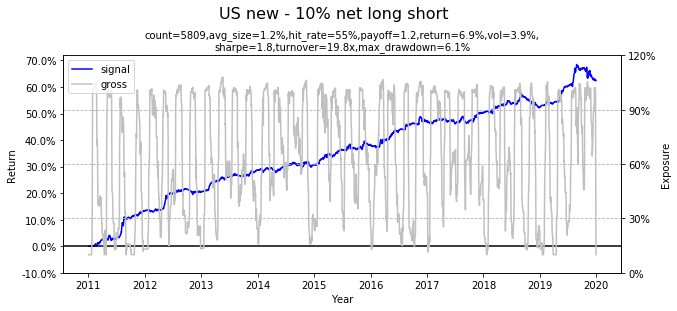

In [353]:
utils.plot_signal("US new - 10% net long short",[10,4],portfolio_cache_v1)

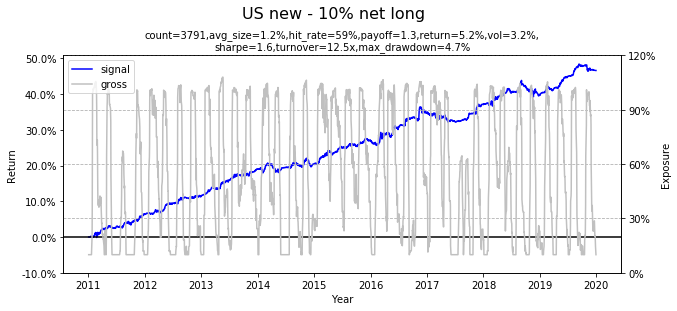

In [356]:
utils.plot_signal("US new - 10% net long",[10,4],portfolio_cache_v1_long)

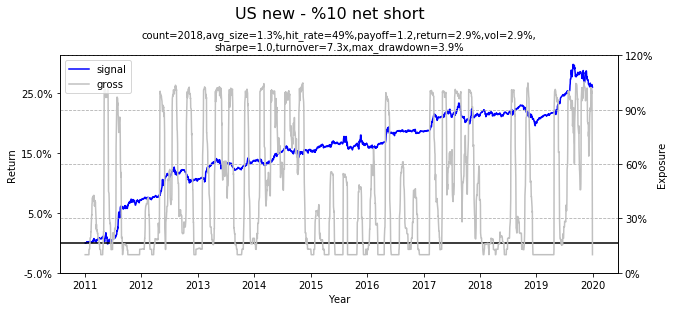

In [358]:
utils.plot_signal("US new - %10 net short",[10,4],portfolio_cache_v1_short)

### Manual version

In [44]:
a_RF,b_RF=rolling_RF_df(X_v1_20d,y_v1_20d,sorted_target_US["post_return_net_20"],41,2,100,10,0.55,True)

In [283]:
b_RF=b_RF_s

In [303]:
RF_quarter_return=sorted_target_US.loc[b_RF[b_RF["pred"]==1].index].groupby(sorted_target_US.loc[b_RF[b_RF["pred"]==1].index]\
                                                                            ["year_quarter"]).apply(np.mean)["post_return_net_20"]

In [306]:
-RF_quarter_return.mean()

0.010857414814999565

In [46]:
RF_quarter_count=sorted_target_US.loc[b_RF[b_RF["pred"]==1].index].\
groupby(sorted_target_US.loc[b_RF[b_RF["pred"]==1].index]["year_quarter"]).apply(lambda x:len(x))

In [47]:
RF_signal=US1.loc[b_RF[b_RF["pred"]==1].index]

In [48]:
''' 
Add another dimension to the multi index
'''
b_RF.set_index('pred_prob', append=True, inplace=True)
b_RF.index.names=["ticker","current_earning","next_earning","quarter_end","pred_prob"]

RF_signal.index=b_RF[b_RF["pred"]==1].index

In [200]:
US_new=utils.signal(fundamental_df=US1,
              price_df=US_price,
              close_return_df=abs_return_US,
              entry=2,
              base=(RF_signal,None),
              holding=20,
              start=pd.Timestamp(2011,1,1),
              end=pd.Timestamp(2019,12,30),
              old_position=False,
              new_signal=False,
              revision_adjust=(False,False),
              early_exit=False)

In [201]:
_long_US,_short_US,_alpha_US,_portfolio_US=US_new.signal_account(stop=None,
                                                           gross=(30,0),
                                                           index_df=abs_return_index_US.loc["SPX Index"].to_frame("US_index"),
                                                           net_level=0,
                                                           risk_parity=False,
                                                           liquidity=0.2,
                                                           capital=60)

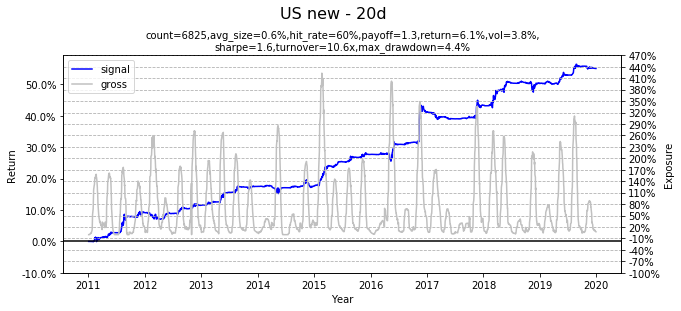

In [202]:
utils.plot_signal("US new - 20d",[10,4],US_new.portfolio_account)

In [88]:
''' 
Build the new version of signal
'''

' \nBuild the new version of signal\n'

In [89]:
old_signal=US_new.long_cache[2]

In [90]:
'''
Assign every old position to 1
'''
signal_count=old_signal.copy()
signal_count[(signal_count>0)|(signal_count<0)]=1

In [91]:
signal_prob=signal_count.apply(lambda x:x*x.name[-1],axis=0)

In [114]:
''' 
New dataframe waiting to be feed into actual signals
'''
new_signal=old_signal.copy()
new_signal[(new_signal>0)|(new_signal<0)]=np.NaN


min_prob=0.55
max_number=50
trade_dict={}
exclude_dict={}
prob_dict={}
for idx,time in enumerate(signal_count.index.tolist()):
    if idx<1:
        target_prob_row=signal_prob.iloc[idx][signal_prob.iloc[idx]>min_prob].sort_values()
        if len(target_prob_row)>max_number:
            target_prob_row=target_prob_row[-max_number:]
        position_list=target_prob_row.index.tolist()
        trade_dict[time]=position_list
        for i in position_list:
            new_signal.loc[time,i]=1
    else:
        target_prob_row=signal_prob.iloc[idx][signal_prob.iloc[idx]>min_prob].sort_values()
        # we have to take out stocks that have count a day ago but not included in the trade list; 
        # the reason is that they must have been eliminated in the day before 
        previous_with_count=signal_count.iloc[idx-1][signal_count.iloc[idx-1]>0]
        row_to_exclude=previous_with_count.loc[~previous_with_count.index.isin(trade_dict[signal_count.index.tolist()[idx-1]])]
        
        if len(row_to_exclude)>0:
            target_prob_row=target_prob_row.loc[~target_prob_row.index.isin(row_to_exclude.index)]
            exclude_dict[time]=row_to_exclude
            prob_dict[time]=target_prob_row

            
        if len(target_prob_row)>max_number:
            target_prob_row=target_prob_row[-max_number:]
        position_list=target_prob_row.index.tolist()
        trade_dict[time]=position_list
        for i in position_list:
            new_signal.loc[time,i]=1
        
        



In [115]:
return_df=abs_return_US.copy()
return_df.columns=[pd.Timestamp(i) for i in abs_return_US.columns]
return_df=return_df.loc[:,new_signal.index[0]:new_signal.index[-1]].T

In [116]:
size=0.012

new_return=new_signal.copy()
new_size=new_signal.copy()
new_pnl=new_signal.copy()

for idx,col in enumerate(new_signal.columns.tolist()):
    target_count=new_signal.loc[:,col]
    new_return.loc[:,col]=target_count*return_df.loc[:,col[0]]
    if len(new_return.loc[:,col].dropna())>0:
        new_return.iloc[target_count.isna().tolist().index(False),idx]=0
    new_size.loc[:,col]=(1+new_return.loc[:,col]).cumprod()*new_size.loc[:,col]*size
    
    new_pnl.loc[:,col]=new_size.loc[:,col].shift(1)*new_return.loc[:,col]
    
    
    

In [122]:
new_return.iloc[:,3].ffill(limit=1).dropna()

2012-05-09    0.000000
2012-05-10   -0.012848
2012-05-11   -0.012848
Name: (1248911D US, 08/May/2012, 02/Aug/2012, 29/Jun/2012, 0.5681118300429676), dtype: float64

In [105]:
new_signal.iloc[:,3].dropna()

2012-05-09    1.0
2012-05-10    1.0
2012-05-11    0.0
2012-05-14    0.0
2012-05-15    0.0
2012-05-16    0.0
2012-05-17    0.0
2012-05-18    0.0
2012-05-21    0.0
2012-05-22    0.0
2012-05-23    0.0
2012-05-24    0.0
2012-05-25    0.0
2012-05-28    0.0
2012-05-29    0.0
2012-05-30    0.0
2012-05-31    0.0
2012-06-01    0.0
2012-06-04    0.0
2012-06-05    0.0
2012-06-06    0.0
Name: (1248911D US, 08/May/2012, 02/Aug/2012, 29/Jun/2012, 0.5681118300429676), dtype: float64

In [62]:
index_return=abs_return_index_US.loc["SPX Index"]
index_return.index=[pd.Timestamp(i) for i in abs_return_index_US.columns]

In [63]:
index_return=index_return.loc[new_signal.index[0]:new_signal.index[-1]]

In [64]:
index_size=0.2-new_size.sum(axis=1)
index_pnl=index_size.shift(1)*index_return

In [65]:
combine_size=pd.concat([new_size,index_size],axis=1)

In [66]:
combine_pnl=pd.concat([new_pnl,index_pnl],axis=1)

In [67]:
new_signal_turnover=new_signal.copy()
new_signal[new_signal.isna()]=0.0

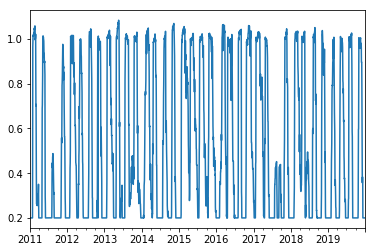

In [68]:
np.abs(combine_size).sum(axis=1).plot()

In [69]:
np.abs(new_signal.diff(1,axis=0)).sum().sum()*0.012/10


10.141200000000001

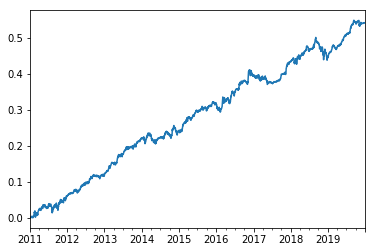

In [70]:
combine_pnl.cumsum().ffill().sum(axis=1).plot()

In [71]:
account_curve=combine_pnl.cumsum().ffill().sum(axis=1)

In [72]:
account_curve.diff(1).mean()*(260)

0.06019412231239045

In [73]:
account_curve.diff(1).std()*(260**0.5)

0.03772327246495036

In [74]:
max_dd=-((1+account_curve)-(1+account_curve).cummax(axis=0)).expanding().min().min()

In [75]:
max_dd

0.063341148205867

In [76]:
account_curve

2011-01-03    0.000000
2011-01-04   -0.000263
2011-01-05    0.000739
2011-01-06    0.000314
2011-01-07   -0.000055
2011-01-10   -0.000330
2011-01-11    0.000472
2011-01-12    0.002111
2011-01-13    0.002137
2011-01-14    0.003344
2011-01-17    0.003344
2011-01-18    0.003996
2011-01-19    0.001542
2011-01-20    0.001347
2011-01-21    0.001247
2011-01-24    0.002473
2011-01-25    0.002032
2011-01-26    0.003595
2011-01-27    0.003992
2011-01-28   -0.000179
2011-01-31    0.000966
2011-02-01    0.003009
2011-02-02    0.003703
2011-02-03    0.002603
2011-02-04    0.003892
2011-02-07    0.004805
2011-02-08    0.006179
2011-02-09    0.005383
2011-02-10    0.009639
2011-02-11    0.012475
                ...   
2019-11-19    0.540949
2019-11-20    0.543776
2019-11-21    0.540274
2019-11-22    0.540338
2019-11-25    0.539378
2019-11-26    0.541805
2019-11-27    0.540624
2019-11-28    0.540624
2019-11-29    0.540414
2019-12-02    0.540264
2019-12-03    0.541284
2019-12-04    0.541353
2019-12-05 

In [77]:
account_curve.diff(1).mean()*2346

0.5431361959418

### 10 day as dependent variable

In [1472]:
dependent_variable="result_net_10"
features=["Market cap",'post_return_net_10_last',"post_revision","pre_revision","stock_mom","stock_mom_short","beta","30d_vol",\
          "EAR_net","EAR_net_last","yield_slope","currency","vix","gold","oil","commodity","EPS_avg",\
         "momentum_long_MA_150","market_MA_50","stock_MA_n_150"]


In [1473]:
X_10=sorted_target_US[features].dropna(how="any",axis=0)
y_10=sorted_target_US[dependent_variable].loc[X.index]

In [1476]:
X1_10=sorted_target_US_1[features].dropna(how="any",axis=0)
y1_10=sorted_target_US_1[dependent_variable].loc[X1_10.index]
X2_10=sorted_target_US_2[features].dropna(how="any",axis=0)
y2_10=sorted_target_US_2[dependent_variable].loc[X2_10.index]
X3_10=sorted_target_US_3[features].dropna(how="any",axis=0)
y3_10=sorted_target_US_3[dependent_variable].loc[X3_10.index]
X4_10=sorted_target_US_4[features].dropna(how="any",axis=0)
y4_10=sorted_target_US_4[dependent_variable].loc[X4_10.index]
X13_10=sorted_target_US_13[features].dropna(how="any",axis=0)
y13_10=sorted_target_US_13[dependent_variable].loc[X13_10.index]

In [1477]:
RF_dict1_10,RF_dict_metrics1_10,RF_pred_dict1_10=rolling_RF_cv(X1_10,y1_10,[21,41],[1,2,3,4],[50,100,200],[5,10,15],[0.5,0.55,0.6],True)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

In [1478]:
RF_dict13_10,RF_dict_metrics13_10,RF_pred_dict13_10=rolling_RF_cv(X13_10,y13_10,[11,21,41],[1,2,3,4],[50,100,200],[5,10,15],[0.5,0.55,0.6],True)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars


In [1479]:
RF_dict_10,RF_dict_metrics_10,RF_pred_dict_10=rolling_RF_cv(X_10,y_10,[11,21,41],[1,2,3,4],[50,100,200],[5,10,15],[0.5,0.55,0.6],True)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\sit

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars


In [1488]:
pd.DataFrame(RF_dict_metrics13_10).T.sort_values(1).loc[21]

0         1            2
2 200 5  0.60  0.518968  0.099694   126.210526
4 50  5  0.60  0.538536  0.201878    79.058824
1 200 5  0.60  0.522005  0.305209   212.250000
4 200 10 0.60  0.552535  0.305963   186.058824
1 50  5  0.60  0.518494  0.335204   292.050000
  100 5  0.55  0.526051  0.351176   644.200000
  50  15 0.50  0.516898  0.376340   954.600000
3 100 5  0.55  0.531553  0.408936   498.388889
2 100 5  0.60  0.555116  0.425409   151.315789
1 100 5  0.50  0.520362  0.432996  1023.550000
  50  5  0.50  0.520198  0.438975  1050.750000
  200 5  0.50  0.520829  0.441502  1039.300000
2 50  5  0.55  0.523894  0.465481   562.473684
1 200 5  0.55  0.560415  0.477421   626.900000
2 200 5  0.50  0.522458  0.486745  1043.421053
4 50  10 0.60  0.552249  0.496327   241.352941
2 100 5  0.50  0.522467  0.500282  1022.894737
3 200 5  0.55  0.547792  0.521098   492.666667
  100 5  0.50  0.527165  0.521967  1004.111111
1 100 15 0.50  0.524708  0.538350   970.200000
2 50  5  0.50  0.523121  0.546255  1021.736842
  200 5  0.55  0.538117  0.546611   504.368421
1 50  5  0.55  0.526244  0.549653   671.500000
3 200 5  0.50  0.528065  0.564393  1007.611111
4 50  5  0.55  0.549863  0.568981   461.705882
3 50  5  0.50  0.528583  0.573914   988.611111
2 100 5  0.55  0.537834  0.575471   516.315789
3 50  10 0.60  0.552570  0.578590   261.777778
1 200 10 0.55  0.552272  0.593273   574.300000
  100 5  0.60  0.536182  0.605015   247.400000
...                 ...       ...          ...
2 100 10 0.55  0.549341  0.848288   556.421053
4 50  15 0.55  0.536598  0.863054   571.647059
1 100 15 0.60  0.580339  0.865679   302.500000
4 100 15 0.50  0.535957  0.866372   951.352941
2 50  5  0.60  0.617006  0.869942   183.631579
4 50  15 0.60  0.549815  0.886714   272.823529
2 100 15 0.60  0.573271  0.891697   254.947368
4 100 5  0.60  0.625098  0.897514    70.235294
1 100 10 0.55  0.552515  0.904508   573.900000
2 200 15 0.60  0.587971  0.905483   212.421053
1 50  10 0.55  0.549789  0.911292   619.400000
2 50  15 0.55  0.542788  0.918792   600.631579
4 100 10 0.60  0.614994  0.923031   212.058824
2 100 15 0.55  0.554608  0.933652   569.368421
4 200 10 0.50  0.542353  0.938312  1016.117647
2 200 10 0.55  0.552441  0.942087   533.000000
4 200 15 0.55  0.555343  0.969562   503.058824
      10 0.55  0.554593  0.970033   549.588235
2 100 10 0.60  0.564887  0.970606   231.842105
4 200 15 0.50  0.541653  0.971676   963.823529
3 200 15 0.55  0.556233  0.989605   532.444444
2 50  15 0.60  0.560533  0.990869   312.105263
4 50  10 0.55  0.548950  1.012972   562.529412
  200 15 0.60  0.581075  1.023980   174.588235
2 200 15 0.55  0.549653  1.024830   548.842105
4 100 15 0.60  0.572499  1.030096   207.882353
      10 0.55  0.550059  1.039679   565.000000
3 200 15 0.60  0.589310  1.044708   206.777778
4 100 15 0.55  0.547137  1.128208   518.058824
3 200 10 0.60  0.627146  1.215491   186.777778

[108 rows x 3 columns]

In [1487]:
pd.DataFrame(RF_dict_metrics1_10).T.sort_values(1).loc[21]

0         1           2
1 50  5  0.55  0.495064 -0.037959  369.500000
3 50  5  0.60  0.542782  0.239319  113.444444
1 200 5  0.55  0.536444  0.259407  335.600000
4 200 10 0.60  0.537207  0.291702  139.352941
      5  0.55  0.536651  0.307892  347.411765
1 100 5  0.60  0.528476  0.325215  148.900000
         0.55  0.522484  0.336803  357.400000
  200 5  0.60  0.555777  0.341656  138.050000
4 200 5  0.60  0.556450  0.348848  101.529412
2 200 5  0.55  0.552916  0.388179  308.947368
3 50  5  0.55  0.542898  0.395830  349.722222
2 100 5  0.60  0.559251  0.399399  108.000000
  50  5  0.55  0.545233  0.405144  347.263158
1 100 5  0.50  0.526570  0.478747  647.100000
  200 5  0.50  0.535335  0.479052  624.050000
      10 0.60  0.554154  0.480986  161.600000
4 100 5  0.60  0.589509  0.498239  102.058824
2 100 5  0.55  0.544674  0.501920  324.526316
4 50  5  0.55  0.567371  0.503390  365.941176
1 50  5  0.50  0.527042  0.519729  626.050000
4 100 5  0.55  0.553063  0.534969  359.117647
2 100 10 0.60  0.565726  0.538548  157.000000
1 50  15 0.50  0.528329  0.538697  599.500000
2 200 5  0.50  0.529607  0.541846  669.210526
3 100 5  0.60  0.576649  0.544774   99.888889
1 200 15 0.60  0.557742  0.548875  158.550000
3 200 5  0.60  0.606623  0.583896  112.666667
1 100 15 0.60  0.561799  0.585709  184.350000
2 50  10 0.60  0.553042  0.588860  169.421053
  100 10 0.50  0.530929  0.589961  635.315789
...                 ...       ...         ...
  200 15 0.55  0.552394  0.839196  349.315789
3 50  15 0.55  0.545100  0.841172  393.277778
4 50  15 0.55  0.546838  0.845253  405.705882
1 100 10 0.55  0.549539  0.851702  379.050000
2 200 10 0.55  0.554186  0.855733  352.000000
  50  15 0.55  0.552619  0.863902  408.315789
4 100 10 0.50  0.541609  0.870219  662.588235
      15 0.50  0.539561  0.871841  644.000000
3 50  10 0.55  0.547539  0.875934  375.500000
  200 10 0.50  0.542615  0.878976  649.833333
1 50  10 0.55  0.545466  0.887424  399.150000
3 200 10 0.60  0.605255  0.894714  139.555556
4 100 15 0.55  0.543131  0.919946  371.823529
1 50  10 0.60  0.566242  0.935638  219.550000
4 50  15 0.60  0.560236  0.980662  205.882353
  200 15 0.50  0.547140  0.992670  643.411765
3 50  10 0.60  0.570077  1.011747  173.277778
4 50  10 0.50  0.545489  1.015422  664.705882
  200 10 0.50  0.545239  1.028798  656.235294
      15 0.55  0.551180  1.041627  348.941176
3 200 10 0.55  0.555263  1.067165  353.611111
      15 0.55  0.561359  1.080824  343.388889
  100 10 0.55  0.564780  1.122281  348.666667
4 200 10 0.55  0.567940  1.166152  350.235294
  100 15 0.60  0.571414  1.186918  163.882353
  50  10 0.60  0.581157  1.187377  197.294118
3 200 15 0.60  0.590097  1.189491  138.444444
  100 10 0.60  0.588322  1.199868  145.833333
4 50  10 0.55  0.566216  1.269491  405.941176
  100 10 0.55  0.557940  1.293057  373.647059

[108 rows x 3 columns]

In [1519]:
pd.DataFrame(RF_dict_metrics1_10).T.sort_values(1).loc[21]

0         1           2
1 50  5  0.55  0.495064 -0.037959  369.500000
3 50  5  0.60  0.542782  0.239319  113.444444
1 200 5  0.55  0.536444  0.259407  335.600000
4 200 10 0.60  0.537207  0.291702  139.352941
      5  0.55  0.536651  0.307892  347.411765
1 100 5  0.60  0.528476  0.325215  148.900000
         0.55  0.522484  0.336803  357.400000
  200 5  0.60  0.555777  0.341656  138.050000
4 200 5  0.60  0.556450  0.348848  101.529412
2 200 5  0.55  0.552916  0.388179  308.947368
3 50  5  0.55  0.542898  0.395830  349.722222
2 100 5  0.60  0.559251  0.399399  108.000000
  50  5  0.55  0.545233  0.405144  347.263158
1 100 5  0.50  0.526570  0.478747  647.100000
  200 5  0.50  0.535335  0.479052  624.050000
      10 0.60  0.554154  0.480986  161.600000
4 100 5  0.60  0.589509  0.498239  102.058824
2 100 5  0.55  0.544674  0.501920  324.526316
4 50  5  0.55  0.567371  0.503390  365.941176
1 50  5  0.50  0.527042  0.519729  626.050000
4 100 5  0.55  0.553063  0.534969  359.117647
2 100 10 0.60  0.565726  0.538548  157.000000
1 50  15 0.50  0.528329  0.538697  599.500000
2 200 5  0.50  0.529607  0.541846  669.210526
3 100 5  0.60  0.576649  0.544774   99.888889
1 200 15 0.60  0.557742  0.548875  158.550000
3 200 5  0.60  0.606623  0.583896  112.666667
1 100 15 0.60  0.561799  0.585709  184.350000
2 50  10 0.60  0.553042  0.588860  169.421053
  100 10 0.50  0.530929  0.589961  635.315789
...                 ...       ...         ...
  200 15 0.55  0.552394  0.839196  349.315789
3 50  15 0.55  0.545100  0.841172  393.277778
4 50  15 0.55  0.546838  0.845253  405.705882
1 100 10 0.55  0.549539  0.851702  379.050000
2 200 10 0.55  0.554186  0.855733  352.000000
  50  15 0.55  0.552619  0.863902  408.315789
4 100 10 0.50  0.541609  0.870219  662.588235
      15 0.50  0.539561  0.871841  644.000000
3 50  10 0.55  0.547539  0.875934  375.500000
  200 10 0.50  0.542615  0.878976  649.833333
1 50  10 0.55  0.545466  0.887424  399.150000
3 200 10 0.60  0.605255  0.894714  139.555556
4 100 15 0.55  0.543131  0.919946  371.823529
1 50  10 0.60  0.566242  0.935638  219.550000
4 50  15 0.60  0.560236  0.980662  205.882353
  200 15 0.50  0.547140  0.992670  643.411765
3 50  10 0.60  0.570077  1.011747  173.277778
4 50  10 0.50  0.545489  1.015422  664.705882
  200 10 0.50  0.545239  1.028798  656.235294
      15 0.55  0.551180  1.041627  348.941176
3 200 10 0.55  0.555263  1.067165  353.611111
      15 0.55  0.561359  1.080824  343.388889
  100 10 0.55  0.564780  1.122281  348.666667
4 200 10 0.55  0.567940  1.166152  350.235294
  100 15 0.60  0.571414  1.186918  163.882353
  50  10 0.60  0.581157  1.187377  197.294118
3 200 15 0.60  0.590097  1.189491  138.444444
  100 10 0.60  0.588322  1.199868  145.833333
4 50  10 0.55  0.566216  1.269491  405.941176
  100 10 0.55  0.557940  1.293057  373.647059

[108 rows x 3 columns]

In [1520]:
(RF_dict1_10[(21,4,50,10,0.55)]<0.5).sum()

hit      3
count    0
dtype: int64

In [1521]:
RF_dict1_10[(21,4,50,10,0.55)]

hit count
4   0.648649    74
5   0.501429   700
6   0.497449   392
7   0.654762    84
8   0.596107   411
9   0.468988   919
10  0.585366   164
11  0.572241   879
12  0.558442   308
13   0.57193   285
14  0.590164   244
15  0.497307   557
16  0.557143    70
17  0.553333   450
18  0.612546   271
19  0.557178   411
20  0.602639   682

In [1421]:
a,b=rolling_RF_df(X1,y1,41,4,100,10,0.55,True)

In [1422]:
confusion_matrix(b["actual"],b["pred"])

array([[7133, 3226],
       [7165, 4461]], dtype=int64)

In [1423]:
b["year"]=b.apply(lambda x:x.name[1][-4:],axis=1)

In [1424]:
confusion_matrix(b[b["year"]=="2019"]["actual"],b[b["year"]=="2019"]["pred"])

array([[831, 112],
       [670, 237]], dtype=int64)

In [1425]:
b.groupby(b["year"]).apply(sum)

actual    pred  year
year                      
2009   425.0   189.0   inf
2010  1135.0   577.0   inf
2011  1055.0  1099.0   inf
2012   884.0   423.0   inf
2013  1162.0  1020.0   inf
2014  1089.0   627.0   inf
2015  1222.0  1191.0   inf
2016  1319.0  1029.0   inf
2017  1092.0   272.0   inf
2018  1336.0   911.0   inf
2019   907.0   349.0   inf

In [1426]:
b[b["year"]=="2019"].sort_values("pred")

actual  pred  year
EXEL US  02/May/2019 01/Aug/2019 28/Jun/2019       1     0  2019
QD US    20/May/2019 16/Aug/2019 28/Jun/2019       1     0  2019
NTES US  16/May/2019 08/Aug/2019 28/Jun/2019       0     0  2019
EXP US   16/May/2019 31/Jul/2019 28/Jun/2019       0     0  2019
NICE US  16/May/2019 08/Aug/2019 28/Jun/2019       0     0  2019
CSCO US  16/May/2019 15/Aug/2019 28/Jun/2019       0     0  2019
DOX US   15/May/2019 08/Aug/2019 28/Jun/2019       0     0  2019
BABA US  15/May/2019 15/Aug/2019 28/Jun/2019       0     0  2019
PAGS US  15/May/2019 16/Aug/2019 28/Jun/2019       1     0  2019
PPDF US  15/May/2019 NaN         28/Jun/2019       0     0  2019
STE US   14/May/2019 06/Aug/2019 28/Jun/2019       1     0  2019
KRNT US  14/May/2019 07/Aug/2019 28/Jun/2019       0     0  2019
GDS US   14/May/2019 13/Aug/2019 28/Jun/2019       0     0  2019
CYBR US  14/May/2019 07/Aug/2019 28/Jun/2019       1     0  2019
LM US    14/May/2019 02/Aug/2019 28/Jun/2019       1     0  2019
SPWR US  10/May/2019 01/Aug/2019 28/Jun/2019       1     0  2019
NTRA US  10/May/2019 08/Aug/2019 28/Jun/2019       1     0  2019
XNCR US  10/May/2019 07/Aug/2019 28/Jun/2019       0     0  2019
JD US    10/May/2019 13/Aug/2019 28/Jun/2019       0     0  2019
SUPV US  10/May/2019 NaN         28/Jun/2019       1     0  2019
AY US    10/May/2019 07/Aug/2019 28/Jun/2019       1     0  2019
CHRS US  10/May/2019 02/Aug/2019 28/Jun/2019       1     0  2019
EV US    21/May/2019 27/Aug/2019 28/Jun/2019       1     0  2019
GPRO US  10/May/2019 02/Aug/2019 28/Jun/2019       0     0  2019
AZO US   21/May/2019 NaN         28/Jun/2019       1     0  2019
DY US    21/May/2019 28/Aug/2019 28/Jun/2019       1     0  2019
BURL US  30/May/2019 29/Aug/2019 28/Jun/2019       1     0  2019
DG US    30/May/2019 29/Aug/2019 28/Jun/2019       0     0  2019
NXGN US  29/May/2019 25/Jul/2019 28/Jun/2019       0     0  2019
HEI US   29/May/2019 28/Aug/2019 28/Jun/2019       1     0  2019
...                                              ...   ...   ...
SBUX US  26/Jul/2019 NaN         30/Sep/2019       1     1  2019
UHS US   26/Jul/2019 NaN         30/Sep/2019       0     1  2019
FII US   26/Jul/2019 NaN         30/Sep/2019       0     1  2019
OGS US   21/Feb/2019 30/Apr/2019 29/Mar/2019       1     1  2019
TFX US   21/Feb/2019 02/May/2019 29/Mar/2019       1     1  2019
CHE US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
RMD US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
GLPG US  26/Jul/2019 NaN         30/Sep/2019       0     1  2019
SYK US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
MCD US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
TNET US  26/Jul/2019 NaN         30/Sep/2019       0     1  2019
HTH US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
ABG US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
INT US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
PNW US   22/Feb/2019 01/May/2019 29/Mar/2019       1     1  2019
BAX US   25/Jul/2019 NaN         30/Sep/2019       1     1  2019
AAN US   25/Jul/2019 NaN         30/Sep/2019       1     1  2019
DANOY US 25/Jul/2019 NaN         30/Sep/2019       1     1  2019
AZN US   25/Jul/2019 NaN         30/Sep/2019       1     1  2019
ICLR US  25/Jul/2019 NaN         30/Sep/2019       1     1  2019
PEG US   27/Feb/2019 02/May/2019 29/Mar/2019       0     1  2019
INTU US  22/Feb/2019 24/May/2019 29/Mar/2019       1     1  2019
HSY US   25/Jul/2019 NaN         30/Sep/2019       1     1  2019
TPX US   25/Jul/2019 NaN         30/Sep/2019       0     1  2019
IART US  21/Feb/2019 24/Apr/2019 29/Mar/2019       1     1  2019
A US     21/Feb/2019 15/May/2019 29/Mar/2019       1     1  2019
WM US    25/Jul/2019 NaN         30/Sep/2019       1     1  2019
KOF US   26/Jul/2019 NaN         30/Sep/2019       0     1  2019
VMC US   25/Jul/2019 NaN         30/Sep/2019       1     1  2019
BBBY US  10/Jan/2019 11/Apr/2019 29/Mar/2019       0     1  2019

[1850 rows x 3 

### Cross validation

In [860]:
rolling_RF_full=rolling_RF(X,y,11,1,100,10)

In [861]:
rolling_RF_full

hit_long_50 hit_short_50 long_pct_50 short_pct_50 hit_long_55 hit_short_55  \
1     0.469173     0.492827    0.664597     0.335403    0.462272     0.494253   
2     0.528398      0.53012    0.729516     0.270484    0.549883     0.510158   
3     0.527085     0.541554    0.254966     0.745034    0.543062     0.549145   
4     0.559322     0.443959    0.466946     0.533054    0.552025     0.467159   
5     0.499141     0.547286    0.722645     0.277355    0.519126     0.552894   
6     0.564934     0.461769    0.689479     0.310521    0.577747     0.428291   
7     0.566339     0.477725    0.836282     0.163718    0.587539     0.535971   
8     0.465438     0.467638    0.808194     0.191806    0.472423     0.456044   
9     0.576814     0.456621    0.218221     0.781779         0.6     0.476149   
10    0.483271     0.509323    0.417443     0.582557    0.487179     0.503303   

   long_pct_55 short_pct_55 hit_long_60 hit_short_60 long_pct_60 short_pct_60  
1     0.390812     0.108024    0.425455     0.507937    0.170728    0.0195561  
2       0.3982    0.0687461    0.556213      0.59322     0.13113    0.0091558  
3     0.129733     0.535227    0.636364     0.579608   0.0546245      0.30897  
4     0.195376     0.210273    0.543175     0.554422   0.0557107    0.0456238  
5     0.369238    0.0777588    0.577206     0.481481   0.0844327    0.0125718  
6     0.340317    0.0789882    0.596413     0.446429    0.103818   0.00869025  
7     0.550435    0.0431409     0.59375     0.566038    0.213532   0.00822471  
8     0.472688    0.0564867     0.51559     0.568627    0.139354    0.0158287  
9    0.0737234     0.533602        0.65     0.496922    0.021729     0.277355  
10    0.114991     0.234947    0.527473     0.498507   0.0141217    0.0519863

In [862]:
(rolling_RF_full.mean()-0.5)/rolling_RF_full.std()

hit_long_50     0.564678
hit_short_50   -0.190766
long_pct_50     0.359356
short_pct_50   -0.359356
hit_long_55     0.724879
hit_short_55   -0.064587
long_pct_55    -1.197799
short_pct_55   -1.606023
hit_long_60     0.955729
hit_short_60    0.596390
long_pct_60    -6.158204
short_pct_60   -3.662443
dtype: float64

In [834]:
rolling_RF_1=rolling_RF(X1,y1,11,2,100,10)
rolling_RF_2=rolling_RF(X2,y2,11,2,100,10)
rolling_RF_3=rolling_RF(X3,y3,11,2,100,10)
rolling_RF_4=rolling_RF(X4,y4,11,2,100,10)


In [869]:
rolling_RF_1=rolling_RF(X1,y1,11,3,100,10)

In [870]:
rolling_RF_1

hit_long_50 hit_short_50 long_pct_50 short_pct_50 hit_long_55 hit_short_55  \
1          NaN          NaN         NaN          NaN         NaN          NaN   
2          NaN          NaN         NaN          NaN         NaN          NaN   
3     0.470822     0.588556    0.827861     0.172139    0.479651     0.647059   
4     0.567713     0.403733    0.522738     0.477262    0.560863     0.429158   
5     0.506749     0.497175    0.833959     0.166041     0.51349     0.532468   
6         0.58     0.418219    0.773558     0.226442     0.58674     0.388889   
7     0.595652     0.460106     0.64728      0.35272    0.605723     0.517391   
8     0.493353     0.637255     0.95218      0.04782    0.510856     0.611111   
9     0.612069     0.524038    0.707317     0.292683    0.621131      0.54955   
10    0.485269     0.470889    0.541022     0.458978    0.485651     0.471471   

   long_pct_55 short_pct_55 hit_long_60 hit_short_60 long_pct_60 short_pct_60  
1          NaN          NaN         NaN          NaN         NaN          NaN  
2          NaN          NaN         NaN          NaN         NaN          NaN  
3     0.484053    0.0318949    0.490706          0.5    0.126173   0.00375235  
4     0.304266     0.228317    0.569579     0.510638    0.144866    0.0440694  
5     0.538931    0.0361163    0.498551          0.5     0.16182   0.00187617  
6     0.424285    0.0506329    0.616114    0.0714286   0.0989217   0.00656353  
7     0.295028      0.10788    0.589744     0.607143   0.0731707    0.0131332  
8     0.777309   0.00843882    0.528504            1    0.394749   0.00140647  
9     0.439493     0.156191    0.651261     0.554745    0.111632    0.0642589  
10    0.212377     0.156118    0.481203     0.461538   0.0623535    0.0243788

In [873]:
(rolling_RF_1.mean()-0.5)/rolling_RF_1.std()

hit_long_50      0.699411
hit_short_50    -0.000044
long_pct_50      1.504797
short_pct_50    -1.504797
hit_long_55      0.822644
hit_short_55     0.210801
long_pct_55     -0.372404
short_pct_55    -5.184914
hit_long_60      0.843349
hit_short_60     0.101938
long_pct_60     -3.342212
short_pct_60   -20.815940
dtype: float64

In [837]:
(rolling_RF_2.mean()-0.5)/rolling_RF_2.std()

hit_long_50     0.397476
hit_short_50    0.019290
long_pct_50     0.048094
short_pct_50   -0.048094
hit_long_55     0.603391
hit_short_55    0.408767
long_pct_55    -1.557254
short_pct_55   -2.033993
hit_long_60     0.549934
hit_short_60    0.513452
long_pct_60    -4.168629
short_pct_60   -6.298190
dtype: float64

In [838]:
(rolling_RF_3.mean()-0.5)/rolling_RF_3.std()

hit_long_50      0.703201
hit_short_50     0.694708
long_pct_50      1.343638
short_pct_50    -1.343638
hit_long_55      0.652396
hit_short_55     0.755398
long_pct_55     -0.652104
short_pct_55    -4.602247
hit_long_60      0.694787
hit_short_60     0.413618
long_pct_60     -3.738176
short_pct_60   -13.199534
dtype: float64

In [839]:
(rolling_RF_4.mean()-0.5)/rolling_RF_4.std()

hit_long_50     0.417125
hit_short_50   -0.103736
long_pct_50     0.810953
short_pct_50   -0.810953
hit_long_55     0.430664
hit_short_55   -0.233239
long_pct_55    -0.201897
short_pct_55   -1.511677
hit_long_60     0.145011
hit_short_60    0.074661
long_pct_60    -2.110819
short_pct_60   -2.538265
dtype: float64

In [701]:
expanding_RF_full=expanding_RF(X,y,11,100,10)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars


In [705]:
expanding_RF_1=expanding_RF(X1,y1,11,100,10)
expanding_RF_2=expanding_RF(X2,y2,11,100,10)
expanding_RF_3=expanding_RF(X3,y3,11,100,10)
expanding_RF_4=expanding_RF(X4,y4,11,100,10)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars


In [704]:
(expanding_RF_full.mean(axis=0)-0.5)/expanding_RF_full.std()

hit_long_50     0.551085
hit_short_50   -0.052492
long_pct_50     1.064997
short_pct_50   -1.064997
hit_long_55     0.791390
hit_short_55    0.032256
long_pct_55    -0.964527
short_pct_55   -2.945023
hit_long_60     0.547875
hit_short_60    0.686504
long_pct_60    -9.328924
short_pct_60   -8.497192
dtype: float64

In [706]:
(expanding_RF_1.mean(axis=0)-0.5)/expanding_RF_1.std()

hit_long_50      0.764570
hit_short_50    -0.092136
long_pct_50      1.435007
short_pct_50    -1.435007
hit_long_55      0.882237
hit_short_55     0.169295
long_pct_55     -0.361710
short_pct_55    -4.253734
hit_long_60      1.194610
hit_short_60     0.492677
long_pct_60     -4.635692
short_pct_60   -14.217549
dtype: float64

In [707]:
(expanding_RF_2.mean(axis=0)-0.5)/expanding_RF_2.std()

hit_long_50     0.239616
hit_short_50    0.122123
long_pct_50     0.424327
short_pct_50   -0.424327
hit_long_55     0.231309
hit_short_55    0.305962
long_pct_55    -2.168797
short_pct_55   -2.170640
hit_long_60     0.145841
hit_short_60    0.047574
long_pct_60    -9.947137
short_pct_60   -4.115423
dtype: float64

In [708]:
(expanding_RF_3.mean(axis=0)-0.5)/expanding_RF_3.std()

hit_long_50     0.497793
hit_short_50    0.306094
long_pct_50     1.475371
short_pct_50   -1.475371
hit_long_55     0.426402
hit_short_55    0.619535
long_pct_55    -1.099640
short_pct_55   -4.222681
hit_long_60     0.353728
hit_short_60    0.688440
long_pct_60    -4.120547
short_pct_60   -9.993799
dtype: float64

In [709]:
(expanding_RF_4.mean(axis=0)-0.5)/expanding_RF_4.std()

hit_long_50     0.354212
hit_short_50    0.488733
long_pct_50     1.381882
short_pct_50   -1.381882
hit_long_55     0.448789
hit_short_55    0.096781
long_pct_55    -1.165022
short_pct_55   -3.310625
hit_long_60     0.486967
hit_short_60   -0.202271
long_pct_60    -6.549539
short_pct_60   -7.106690
dtype: float64

In [698]:
(rolling_RF_full.mean(axis=0)-0.5)/rolling_RF_full.std()

hit_long_50     0.488607
hit_short_50   -0.129386
long_pct_50     0.321539
short_pct_50   -0.321539
hit_long_55     0.568513
hit_short_55   -0.089092
long_pct_55    -1.208688
short_pct_55   -1.899139
hit_long_60     0.760118
hit_short_60    0.416964
long_pct_60    -5.879018
short_pct_60   -5.315011
dtype: float64

In [693]:
(rolling_RF_1.mean(axis=0)-0.5)/rolling_RF_1.std()

hit_long_50     0.751059
hit_short_50   -0.548758
long_pct_50     0.323091
short_pct_50   -0.323091
hit_long_55     0.897942
hit_short_55   -0.025441
long_pct_55    -0.745602
short_pct_55   -1.642448
hit_long_60     0.470273
hit_short_60    0.294584
long_pct_60    -2.598574
short_pct_60   -4.699457
dtype: float64

In [694]:
(rolling_RF_2.mean(axis=0)-0.5)/rolling_RF_2.std()

hit_long_50     0.120839
hit_short_50   -0.020493
long_pct_50    -0.271577
short_pct_50    0.271577
hit_long_55     0.091604
hit_short_55    0.355697
long_pct_55    -1.790241
short_pct_55   -1.043385
hit_long_60    -0.073469
hit_short_60    0.339979
long_pct_60    -4.959900
short_pct_60   -3.315729
dtype: float64

In [695]:
(rolling_RF_3.mean(axis=0)-0.5)/rolling_RF_3.std()

hit_long_50      0.754473
hit_short_50     0.596295
long_pct_50      0.942950
short_pct_50    -0.942950
hit_long_55      1.016781
hit_short_55     0.674402
long_pct_55     -0.290034
short_pct_55    -3.299113
hit_long_60      0.980150
hit_short_60    -0.251017
long_pct_60     -1.763821
short_pct_60   -10.418146
dtype: float64

In [696]:
(rolling_RF_4.mean(axis=0)-0.5)/rolling_RF_4.std()

hit_long_50     0.460153
hit_short_50    0.415602
long_pct_50     0.334311
short_pct_50   -0.334311
hit_long_55     0.518026
hit_short_55    0.151932
long_pct_55    -0.782662
short_pct_55   -1.554812
hit_long_60     0.762212
hit_short_60   -0.012583
long_pct_60    -2.776961
short_pct_60   -3.424390
dtype: float64

In [666]:
clf.predict_proba(X)[:,1]

array([0.51734039, 0.46958248, 0.51214265, ..., 0.46759063, 0.49297477,
       0.41499417])

In [673]:
X.shape

(70881, 19)

In [671]:
confusion.sum().sum()

70881

In [665]:
confusion[:,1][-1]/confusion[:,1].sum()

0.6516837073714445

In [669]:
confusion[:,0][0]/confusion[:,0].sum()

0.7433135215453195

In [662]:
confusion

array([[18009, 16250],
       [ 6219, 30403]], dtype=int64)

In [615]:
def expanding_RF(sorted_X,sorted_y,bins,n_estimators,max_depth):
    RF_dict={}
    for i in range(1,bins):
        X_train=sorted_X.iloc[:round(sorted_X.shape[0]*(i)/bins)]
        y_train=sorted_y.iloc[:round(sorted_y.shape[0]*(i)/bins)]
        X_test=sorted_X.iloc[round(sorted_X.shape[0]*(i)/bins):round(sorted_X.shape[0]*(i+1)/bins)]
        y_test=sorted_y.iloc[round(sorted_y.shape[0]*(i)/bins):round(sorted_y.shape[0]*(i+1)/bins)]
            
        clf=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
        clf.fit(X_train,y_train)
        RF_dict[i]=confusion_matrix(y_test,clf.predict(X_test))
    return RF_dict
            
    

In [632]:
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [637]:
confusion_matrix(y,clf.predict(X))

array([[18009, 16250],
       [ 6219, 30403]], dtype=int64)

In [616]:
expanding_RF_full=expanding_RF(X,y,11,100,11)

In [617]:
expanding_RF_full[1]

array([[1166, 2172],
       [1152, 1953]], dtype=int64)

In [618]:
expanding_RF_full[2]

array([[ 624, 2517],
       [ 630, 2673]], dtype=int64)

In [619]:
expanding_RF_full[3]

array([[2464,  913],
       [2176,  891]], dtype=int64)

In [620]:
expanding_RF_full[4]

array([[1282, 1569],
       [1541, 2052]], dtype=int64)

In [621]:
expanding_RF_full[5]

array([[ 634, 2676],
       [ 532, 2601]], dtype=int64)

In [622]:
expanding_RF_full[6]

array([[ 331, 2526],
       [ 463, 3124]], dtype=int64)

In [623]:
expanding_RF_full[7]

array([[ 511, 2330],
       [ 552, 3051]], dtype=int64)

In [624]:
expanding_RF_full[8]

array([[ 274, 3088],
       [ 251, 2831]], dtype=int64)

In [625]:
expanding_RF_full[9]

array([[1325, 1570],
       [1308, 2240]], dtype=int64)

In [626]:
expanding_RF_full[10]

array([[ 394, 2908],
       [ 524, 2618]], dtype=int64)

In [599]:
rolling_RF_full=rolling_RF(X,y,11,100,11)

In [600]:
rolling_RF_full[1]

array([[1577, 1761],
       [1561, 1544]], dtype=int64)

In [601]:
rolling_RF_full[2]

array([[ 688, 2453],
       [ 675, 2628]], dtype=int64)

In [602]:
rolling_RF_full[3]

array([[2564,  813],
       [2150,  917]], dtype=int64)

In [603]:
rolling_RF_full[4]

array([[1683, 1168],
       [2117, 1476]], dtype=int64)

In [604]:
rolling_RF_full[5]

array([[ 955, 2355],
       [ 801, 2332]], dtype=int64)

In [605]:
rolling_RF_full[6]

array([[ 800, 2057],
       [ 908, 2679]], dtype=int64)

In [606]:
rolling_RF_full[7]

array([[ 514, 2327],
       [ 530, 3073]], dtype=int64)

In [607]:
rolling_RF_full[8]

array([[ 700, 2662],
       [ 706, 2376]], dtype=int64)

In [608]:
rolling_RF_full[9]

array([[2365,  530],
       [2816,  732]], dtype=int64)

In [609]:
rolling_RF_full[10]

array([[1862, 1440],
       [1881, 1261]], dtype=int64)

In [544]:
rolling_RF_1=rolling_RF(X1,y1,5,100,10)

In [546]:
rolling_RF_1[1]

array([[1325,  905],
       [1267, 1194]], dtype=int64)

In [547]:
rolling_RF_1[2]

array([[ 863, 1240],
       [1050, 1539]], dtype=int64)

In [548]:
rolling_RF_1[3]

array([[ 508, 1635],
       [ 597, 1951]], dtype=int64)

In [549]:
rolling_RF_1[4]

array([[ 969, 1214],
       [ 985, 1524]], dtype=int64)

In [550]:
rolling_RF_2=rolling_RF(X2,y2,5,100,10)

In [551]:
rolling_RF_2[1]

array([[551, 601],
       [490, 638]], dtype=int64)

In [552]:
rolling_RF_2[2]

array([[732, 362],
       [787, 398]], dtype=int64)

In [553]:
rolling_RF_2[3]

array([[430, 589],
       [517, 744]], dtype=int64)

In [554]:
rolling_RF_2[4]

array([[633, 567],
       [514, 565]], dtype=int64)

In [555]:
rolling_RF_3=rolling_RF(X3,y3,5,100,10)

In [556]:
rolling_RF_3[1]

array([[675, 465],
       [649, 577]], dtype=int64)

In [557]:
rolling_RF_3[2]

array([[ 173,  980],
       [ 175, 1039]], dtype=int64)

In [558]:
rolling_RF_3[3]

array([[ 206,  942],
       [ 174, 1044]], dtype=int64)

In [559]:
rolling_RF_3[4]

array([[328, 811],
       [319, 908]], dtype=int64)

In [560]:
rolling_RF_4=rolling_RF(X4,y4,5,100,10)

In [561]:
rolling_RF_4[1]

array([[ 314, 1869],
       [ 308, 1822]], dtype=int64)

In [562]:
rolling_RF_4[2]

array([[1062, 1017],
       [1078, 1155]], dtype=int64)

In [563]:
rolling_RF_4[3]

array([[ 447, 1575],
       [ 399, 1892]], dtype=int64)

In [564]:
rolling_RF_4[4]

array([[1507,  709],
       [1288,  808]], dtype=int64)

In [565]:
X1

Market cap  \
AMSC US     31/Jan/2008 08/May/2008 31/Mar/2008    6.724737   
MA US       31/Jan/2008 29/Apr/2008 31/Mar/2008   10.213583   
BCO US      31/Jan/2008 30/Apr/2008 31/Mar/2008    7.985019   
RSTI US     31/Jan/2008 30/Apr/2008 31/Mar/2008    7.180974   
RTN US      31/Jan/2008 24/Apr/2008 31/Mar/2008   10.238711   
RX US       31/Jan/2008 17/Apr/2008 31/Mar/2008    8.441275   
SFG US      31/Jan/2008 22/Apr/2008 31/Mar/2008    7.707029   
CYT US      31/Jan/2008 18/Apr/2008 31/Mar/2008    7.831470   
ODFL US     31/Jan/2008 23/Apr/2008 31/Mar/2008    6.991038   
1339658D US 31/Jan/2008 29/Apr/2008 31/Mar/2008    6.899451   
OI US       31/Jan/2008 01/May/2008 31/Mar/2008    8.824071   
CELG US     31/Jan/2008 08/May/2008 31/Mar/2008    9.982789   
CVS US      31/Jan/2008 01/May/2008 31/Mar/2008   10.958946   
SNA US      31/Jan/2008 22/Apr/2008 31/Mar/2008    7.834284   
VVC US      31/Jan/2008 01/May/2008 31/Mar/2008    7.641099   
CNQR US     31/Jan/2008 01/May/2008 31/Mar/2008    7.123916   
HP US       31/Jan/2008 01/May/2008 31/Mar/2008    8.311584   
HOLX US     31/Jan/2008 01/May/2008 31/Mar/2008    9.010685   
HHS US      31/Jan/2008 24/Apr/2008 31/Mar/2008    7.032472   
UAA US      31/Jan/2008 29/Apr/2008 31/Mar/2008    7.578721   
FLO US      31/Jan/2008 22/May/2008 31/Mar/2008    7.694642   
LEARQ US    31/Jan/2008 29/Apr/2008 31/Mar/2008    7.726700   
LANC US     31/Jan/2008 01/May/2008 31/Mar/2008    6.948864   
TKR US      31/Jan/2008 30/Apr/2008 31/Mar/2008    7.970966   
KEX US      31/Jan/2008 24/Apr/2008 31/Mar/2008    7.757533   
WU US       31/Jan/2008 22/Apr/2008 31/Mar/2008    9.728867   
TTEK US     31/Jan/2008 01/May/2008 31/Mar/2008    7.006931   
GBCI US     01/Feb/2008 25/Apr/2008 31/Mar/2008    6.905699   
BCR US      01/Feb/2008 24/Apr/2008 31/Mar/2008    9.191741   
MEE US      01/Feb/2008 25/Apr/2008 31/Mar/2008    7.989345   
...                                                     ...   
KEYS US     30/May/2019 22/Aug/2019 28/Jun/2019    9.502890   
CSIQ US     30/May/2019 15/Aug/2019 28/Jun/2019    7.050704   
BITA US     30/May/2019 05/Sep/2019 28/Jun/2019    6.615493   
DG US       30/May/2019 29/Aug/2019 28/Jun/2019   10.398397   
VRNT US     30/May/2019 05/Sep/2019 28/Jun/2019    8.237303   
BURL US     30/May/2019 29/Aug/2019 28/Jun/2019    9.246113   
VEEV US     30/May/2019 28/Aug/2019 28/Jun/2019    9.891980   
OKTA US     31/May/2019 29/Aug/2019 28/Jun/2019    9.406073   
GCO US      31/May/2019 06/Sep/2019 28/Jun/2019    6.659470   
ULTA US     31/May/2019 30/Aug/2019 28/Jun/2019    9.862719   
COO US      31/May/2019 30/Aug/2019 28/Jun/2019    9.556956   
BIG US      31/May/2019 30/Aug/2019 28/Jun/2019    7.004151   
ASND US     31/May/2019 29/Aug/2019 28/Jun/2019    8.704058   
WSM US      31/May/2019 29/Aug/2019 28/Jun/2019    8.310342   
NAV US      04/Jun/2019 04/Sep/2019 28/Jun/2019    8.121792   
COUP US     04/Jun/2019 04/Sep/2019 28/Jun/2019    8.745936   
HQY US      05/Jun/2019 04/Sep/2019 28/Jun/2019    8.321316   
CPB US      05/Jun/2019 30/Aug/2019 28/Jun/2019    9.443610   
CRM US      05/Jun/2019 23/Aug/2019 28/Jun/2019   11.668591   
SMAR US     06/Jun/2019 05/Sep/2019 28/Jun/2019    8.372781   
CIEN US     06/Jun/2019 05/Sep/2019 28/Jun/2019    8.856511   
SAIC US     06/Jun/2019 06/Sep/2019 28/Jun/2019    8.519956   
ABM US      06/Jun/2019 06/Sep/2019 28/Jun/2019    7.811726   
CASY US     11/Jun/2019 10/Sep/2019 28/Jun/2019    8.491536   
RH US       13/Jun/2019 11/Sep/2019 28/Jun/2019    7.462904   
LULU US     13/Jun/2019 06/Sep/2019 28/Jun/2019   10.010672   
OXM US      13/Jun/2019 12/Sep/2019 28/Jun/2019    7.065631   
ADBE US     19/Jun/2019 18/Sep/2019 28/Jun/2019   11.813438   
ORCL US     20/Jun/2019 12/Sep/2019 28/Jun/2019   12.100946   
APOG US     27/Jun/2019 17/Sep/2019 28/Jun/2019    7.059154   

                                                 post_return_net_20_last  \
AMSC US     31/Jan/2008 08/May/2008 31/Mar/2008                -0.

In [513]:
clf.fit(X1,y1)
feature_imp1 = pd.Series(clf.feature_importances_,index=X1.columns).sort_values(ascending=False)
feature_imp1

beta                       0.075919
currency                   0.059199
30d_vol                    0.057934
momentum_long_MA_150       0.055371
stock_mom                  0.055276
yield_slope                0.054260
gold                       0.053263
commodity                  0.052292
post_return_net_20_last    0.050865
stock_MA_n_150             0.050082
pre_revision               0.047306
oil                        0.045883
vix                        0.045723
EAR_net_last               0.045177
stock_mom_short            0.044510
EAR_net                    0.044411
market_MA_50               0.043547
post_revision              0.043415
Market cap                 0.042958
market_return_60           0.032607
dtype: float64

In [514]:
clf.fit(X2,y2)
feature_imp2=pd.Series(clf.feature_importances_,index=X2.columns).sort_values(ascending=False)
feature_imp2

stock_mom_short            0.060540
beta                       0.057940
post_return_net_20_last    0.056176
30d_vol                    0.054826
currency                   0.054001
EAR_net                    0.052187
stock_mom                  0.051845
Market cap                 0.051783
stock_MA_n_150             0.051268
yield_slope                0.051255
oil                        0.049714
pre_revision               0.049327
EAR_net_last               0.048134
gold                       0.047864
commodity                  0.047839
post_revision              0.047405
momentum_long_MA_150       0.045339
market_MA_50               0.045300
vix                        0.040643
market_return_60           0.036612
dtype: float64

In [515]:
clf.fit(X3,y3)
feature_imp3=pd.Series(clf.feature_importances_,index=X2.columns).sort_values(ascending=False)
feature_imp3

beta                       0.068576
30d_vol                    0.064045
post_return_net_20_last    0.060238
yield_slope                0.057438
stock_mom                  0.055290
stock_mom_short            0.050715
EAR_net                    0.050625
Market cap                 0.050622
stock_MA_n_150             0.050158
momentum_long_MA_150       0.049736
oil                        0.047763
post_revision              0.047625
pre_revision               0.047225
market_MA_50               0.046509
gold                       0.045658
EAR_net_last               0.045297
vix                        0.044156
currency                   0.042895
commodity                  0.040013
market_return_60           0.035414
dtype: float64

In [516]:
clf.fit(X4,y4)
feature_imp4=pd.Series(clf.feature_importances_,index=X2.columns).sort_values(ascending=False)
feature_imp4

stock_mom                  0.061241
beta                       0.059931
30d_vol                    0.057286
oil                        0.057026
currency                   0.056422
yield_slope                0.055733
stock_MA_n_150             0.055060
momentum_long_MA_150       0.053492
pre_revision               0.052522
Market cap                 0.050962
stock_mom_short            0.050786
commodity                  0.050530
post_return_net_20_last    0.047387
EAR_net_last               0.046627
EAR_net                    0.045998
vix                        0.045543
post_revision              0.043858
gold                       0.042631
market_MA_50               0.036850
market_return_60           0.030115
dtype: float64

In [517]:
feature_imp=(feature_imp1+feature_imp2+feature_imp3+feature_imp4)/4

In [518]:
feature_imp.sort_values(ascending =False)

beta                       0.065592
30d_vol                    0.058523
stock_mom                  0.055913
yield_slope                0.054672
post_return_net_20_last    0.053666
currency                   0.053129
stock_MA_n_150             0.051642
stock_mom_short            0.051637
momentum_long_MA_150       0.050985
oil                        0.050097
pre_revision               0.049095
Market cap                 0.049081
EAR_net                    0.048305
commodity                  0.047669
gold                       0.047354
EAR_net_last               0.046309
post_revision              0.045576
vix                        0.044016
market_MA_50               0.043052
market_return_60           0.033687
dtype: float64

## Linear regression

In [402]:
sorted_target_US["post_revision_2"]=sorted_target_US["post_revision"]*sorted_target_US["post_revision"].abs()

In [403]:
sorted_target_US["EAR_net_2"]=sorted_target_US["EAR_net"]*sorted_target_US["EAR_net"].abs()

In [43]:
dependent_variable="post_return_net_20"
features=["Market cap","post_revision","pre_revision","stock_mom","stock_mom_short","30d_vol",\
          "EAR_net","yield_slope","currency",\
         "momentum_long_MA_150",
         "stock_chart_position_120"]


In [210]:
dependent_variable="post_return_net_20"
features=["Market cap","post_revision_category","stock_mom_short","30d_vol",\
          "EAR_net_category"]

In [260]:
dependent_variable="post_return_net_20"
features=["Market cap","post_revision","30d_vol",\
          "EAR_net","yield_slope"]

In [261]:
y=sorted_target_US[dependent_variable]
X=sorted_target_US[features]
combine=pd.concat([X,y],axis=1)

In [212]:
quarter_series=sorted_target_US.apply(lambda x:str(x["Date_timestamp"].year)+quarter(x["Date_timestamp"].month),axis=1)
year_series=sorted_target_US.apply(lambda x:str(x["Date_timestamp"].year),axis=1)

In [213]:
year_series=sorted_target_US.apply(lambda x:str(x["Date_timestamp"].year),axis=1)

In [262]:
param_year=pd.DataFrame(index=year_series.unique(),columns=features)
for i in year_series.unique():
    ols = sm.OLS(y.loc[year_series==i], X.loc[year_series==i])
    ols_result=ols.fit()
    param_year.loc[i]=ols_result.tvalues

In [263]:
param_year

Market cap post_revision   30d_vol    EAR_net yield_slope
2008   0.577045       4.60722  -15.1702    2.17789      6.0081
2009   -1.08615       3.02278  0.415175    3.71037  0.00509505
2010    2.90167      -1.60878  -5.46699     1.4257     0.24326
2011    4.08187       0.98609  -6.72566    -2.2316    -3.24416
2012    7.00351     -0.377474   2.14766  0.0835428    -7.80638
2013  -0.633949      0.806339   5.56396    2.54783   -0.142256
2014    1.83566       2.75156  -2.78403  -0.716199    -1.66173
2015   -0.94392      -1.93489  -2.83047    2.14033     2.48821
2016   -3.15592       2.81024   10.1152   -6.46396     2.67079
2017    4.90631       2.81397  -1.79364   0.747128    -6.24278
2018   -5.32274       0.72261 -0.479704   -1.98354     7.23844
2019    2.52033       1.41575  -9.04101    4.15807    0.884464

In [265]:
print((param_year>0.5).sum()/12)
print((param_year<-0.5).sum()/12)


Market cap       0.583333
post_revision    0.750000
30d_vol          0.250000
EAR_net          0.583333
yield_slope      0.416667
dtype: float64
Market cap       0.416667
post_revision    0.166667
30d_vol          0.583333
EAR_net          0.333333
yield_slope      0.333333
dtype: float64


In [258]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     post_return_net_20   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     28.26
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           1.49e-57
Time:                        09:42:58   Log-Likelihood:                 4146.9
No. Observations:                3728   AIC:                            -8272.
Df Residuals:                    3717   BIC:                            -8203.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Market cap                   0.0077      0.001      7.748      0.000       0.006       0.010
post_revision                0.0059      0.010      0.594      0.553      -0.013       0.025
pre_revision                -0.0001      0.009     -0.013      0.989      -0.017       0.017
stock_mom                    0.0278      0.004      6.526      0.000       0.019       0.036
stock_mom_short              0.0086      0.020      0.436      0.663      -0.030       0.047
30d_vol                     -0.5035      0.156     -3.235      0.001      -0.809      -0.198
EAR_net                      0.0582      0.020      2.844      0.004       0.018       0.098
yield_slope                  0.0646      0.022      2.996      0.003       0.022       0.107
currency                    -0.0008      0.000     -7.660      0.000      -0.001      -0.001
momentum_long_MA_150         0.1163      0.063      1.860      0.063      -0.006       0.239
stock_chart_position_120     0.0023      0.007      0.354      0.723      -0.010       0.015
==============================================================================
Omnibus:                      497.453   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6226.628
Skew:                           0.068   Prob(JB):                         0.00
Kurtosis:                       9.330   Cond. No.                     1.16e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [240]:
ols = sm.OLS(y, X)
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     post_return_net_20   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     22.85
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           6.87e-19
Time:                        09:40:11   Log-Likelihood:                 73658.
No. Observations:               70097   AIC:                        -1.473e+05
Df Residuals:                   70093   BIC:                        -1.473e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
post_revision       0.0323      0.006      5.850      0.000       0.021       0.043
post_revision_2    -0.0232      0.007     -3.095      0.002      -0.038      -0.008
EAR_net            -0.0050      0.006     -0.762      0.446      -0.018       0.008
EAR_net_2           0.0523      0.025      2.109      0.035       0.004       0.101
==============================================================================
Omnibus:                    25570.187   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1387111.363
Skew:                          -0.975   Prob(JB):                         0.00
Kurtosis:                      24.705   Cond. No.                         14.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## clusturing

In [1397]:
dependent_variable="result_net_20"
features=["Market cap","post_revision","pre_revision","stock_mom","stock_mom_short","30d_vol",\
          "EAR_net","yield_slope","currency","oil",\
         "momentum_long_MA_150",
         "stock_chart_position_120"]


In [1398]:
sorted_target_US=target_US.sort_values("Date_timestamp")

In [1399]:
y=sorted_target_US[dependent_variable]
X=sorted_target_US[features]
combine=pd.concat([X,y],axis=1)

y_train=y.iloc[:60000]
X_train=X.iloc[:60000]
combine_train=pd.concat([X_train,y_train],axis=1)

y_test=y.iloc[60000:]
X_test=X.iloc[60000:]
combine_test=pd.concat([X_test,y_test],axis=1)


In [1400]:
X_norm=X.apply(lambda x: (x-x.mean())/x.std(),axis=0)
X_train_norm=X_train.apply(lambda x: (x-x.mean())/x.std(),axis=0)
X_test_norm=X_test.apply(lambda x: (x-x.mean())/x.std(),axis=0)


In [1401]:
from sklearn.cluster import KMeans
k=5
kmeans = KMeans(n_clusters=k,max_iter=10000)
kmeans.fit(X_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [1402]:
labels=kmeans.predict(X_norm)
labels_train = kmeans.predict(X_train_norm)
labels_test = kmeans.predict(X_test_norm)
centroids = kmeans.cluster_centers_

In [1394]:
centroids[3]

array([-0.1956239 , -0.3820625 , -0.13398691, -0.2627199 , -0.40961425,
        0.02621445, -0.65836883, -0.69688514,  0.82875818,  0.98101944,
       -0.14203316, -0.84460258,  0.20907702, -0.01670065, -1.11203287,
        0.0154625 ])

In [1403]:
X_dict={}
for i in range(0,k):
    X_dict[i]=X[labels==i]

In [1404]:
y_dict={}
for i in range(0,k):
    y_dict[i]=y[labels==i]

In [1405]:
X_train_dict={}
for i in range(0,k):
    X_train_dict[i]=X_train[labels_train==i]

In [1406]:
y_train_dict={}
for i in range(0,k):
    y_train_dict[i]=y_train[labels_train==i]

In [1407]:
X_test_dict={}
for i in range(0,k):
    X_test_dict[i]=X_test[labels_test==i]

In [1408]:
y_test_dict={}
for i in range(0,k):
    y_test_dict[i]=y_test[labels_test==i]

In [1318]:
lm = linear_model.LogisticRegression()
lm.fit(X_train,y_train)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [1319]:
lm.score(X_train,y_train)

0.5357

In [1320]:
lm.predict_proba(X_test_dict[i])[:,1]

array([0.50740707, 0.49507401, 0.49405433, ..., 0.34224462, 0.34514701,
       0.31241488])

In [1321]:

accuracy_dict_LR={}
precision_dict_LR={}
for i in range(0,k):
    lm = linear_model.LogisticRegression()
    lm.fit(X_train_dict[i],y_train_dict[i])
    print(confusion_matrix(y_test_dict[i],lm.predict(X_test_dict[i])))
    accuracy_dict_LR[i]=accuracy_score(y_test_dict[i],lm.predict(X_test_dict[i]))
    precision_dict_LR[i]=average_precision_score(y_test_dict[i],lm.predict_proba(X_test_dict[i])[:,1])

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[  0 114]
 [  0 147]]
[[1771    0]
 [2413    0]]
[[2433   16]
 [2100   11]]
[[ 44 160]
 [ 49 263]]


C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[ 71 632]
 [ 64 593]]


In [1322]:
accuracy_dict_LR

{0: 0.5632183908045977,
 1: 0.4232791586998088,
 2: 0.5359649122807018,
 3: 0.5949612403100775,
 4: 0.48823529411764705}

In [1323]:
precision_dict_LR

{0: 0.5580287660475017,
 1: 0.5852389207598049,
 2: 0.4469799063852775,
 3: 0.6373954452072231,
 4: 0.5222659599379564}

In [1324]:
clf=RandomForestClassifier(n_estimators=100,max_depth=10)
clf.fit(X_train,y_train)
accuracy_score(y_test,clf.predict(X_test))

0.5328554360812425

In [1424]:
accuracy_dict_RF={}
precision_dict_RF={}
for i in range(0,k):
    clf=RandomForestClassifier(n_estimators=10,max_depth=5)
    clf.fit(X_dict[i].iloc[:int(X_dict[i].shape[0]*0.8)],y_dict[i].iloc[:int(y_dict[i].shape[0]*0.8)])
    print(confusion_matrix(y_dict[i].iloc[:int(y_dict[i].shape[0]*0.8)],clf.predict(X_dict[i].iloc[:int(X_dict[i].shape[0]*0.8)])))
    print(confusion_matrix(y_dict[i].iloc[int(y_dict[i].shape[0]*0.8):],clf.predict(X_dict[i].iloc[int(X_dict[i].shape[0]*0.8):])))
    #accuracy_dict_RF[i]=accuracy_score(y_test_dict[i],clf.predict(X_test_dict[i]))
    #precision_dict_RF[i]=average_precision_score(y_test_dict[i],clf.predict_proba(X_test_dict[i])[:,1])

[[1282  525]
 [ 606 1072]]
[[251 246]
 [209 166]]
[[2807 2094]
 [1719 3476]]
[[479 777]
 [481 788]]
[[1848 5039]
 [ 965 7070]]
[[ 633 1247]
 [ 621 1230]]
[[1562 3109]
 [ 816 4593]]
[[ 177 1149]
 [ 189 1005]]
[[2617 6050]
 [1377 8076]]
[[ 333 2034]
 [ 295 1868]]


In [1417]:
accuracy_dict_RF={}
precision_dict_RF={}
for i in range(0,k):
    clf=RandomForestClassifier(n_estimators=100,max_depth=10)
    clf.fit(X_dict[i].iloc[:int(X_dict[i].shape[0]*0.6)],y_dict[i].iloc[:int(y_dict[i].shape[0]*0.6)])
    print(confusion_matrix(y_dict[i].iloc[int(y_dict[i].shape[0]*0.8):],clf.predict(X_dict[i].iloc[int(X_dict[i].shape[0]*0.8):])))
    #accuracy_dict_RF[i]=accuracy_score(y_test_dict[i],clf.predict(X_test_dict[i]))
    #precision_dict_RF[i]=average_precision_score(y_test_dict[i],clf.predict_proba(X_test_dict[i])[:,1])

[[185 312]
 [165 210]]
[[556 700]
 [598 671]]
[[ 718 1162]
 [ 659 1192]]
[[1038  288]
 [ 969  225]]
[[ 551 1816]
 [ 510 1653]]


In [1415]:
accuracy_dict_RF={}
precision_dict_RF={}
for i in range(0,k):
    clf=RandomForestClassifier(n_estimators=100,max_depth=10)
    clf.fit(X_dict[i].iloc[:int(X_dict[i].shape[0]*0.6)],y_dict[i].iloc[:int(y_dict[i].shape[0]*0.6)])
    print(confusion_matrix(y_dict[i].iloc[int(y_dict[i].shape[0]*0.6):int(y_dict[i].shape[0]*0.8)],clf.predict(X_dict[i].iloc[int(X_dict[i].shape[0]*0.6):int(X_dict[i].shape[0]*0.8)])))
    #accuracy_dict_RF[i]=accuracy_score(y_test_dict[i],clf.predict(X_test_dict[i]))
    #precision_dict_RF[i]=average_precision_score(y_test_dict[i],clf.predict_proba(X_test_dict[i])[:,1])

[[293 158]
 [200 220]]
[[702 420]
 [821 581]]
[[ 553 1158]
 [ 515 1505]]
[[ 965  169]
 [1162  224]]
[[ 482 1603]
 [ 592 1853]]


In [1420]:
accuracy_dict_RF={}
precision_dict_RF={}
for i in range(0,k):
    clf=RandomForestClassifier(n_estimators=100,max_depth=10)
    clf.fit(X_dict[i].iloc[:int(X_dict[i].shape[0]*0.4)],y_dict[i].iloc[:int(y_dict[i].shape[0]*0.4)])
    print(confusion_matrix(y_dict[i].iloc[int(y_dict[i].shape[0]*0.4):int(y_dict[i].shape[0]*0.6)],clf.predict(X_dict[i].iloc[int(X_dict[i].shape[0]*0.4):int(X_dict[i].shape[0]*0.6)])))
    #accuracy_dict_RF[i]=accuracy_score(y_test_dict[i],clf.predict(X_test_dict[i]))
    #precision_dict_RF[i]=average_precision_score(y_test_dict[i],clf.predict_proba(X_test_dict[i])[:,1])

[[361  83]
 [312 116]]
[[713 639]
 [529 643]]
[[ 239 1778]
 [ 227 1486]]
[[356 972]
 [272 920]]
[[ 333 1993]
 [ 277 1927]]


In [1418]:
accuracy_dict_RF

{}

In [1419]:
precision_dict_RF

{}

## decision tree

In [910]:
from sklearn.tree import DecisionTreeClassifier

In [907]:
dependent_variable="result_net_5"
features=["Market cap","post_revision","pre_revision","stock_mom","stock_mom_short","beta","30d_vol",\
          "EAR_net","yield_long","yield_slope","inflation","currency","vix","gold","oil","commodity",\
         "momentum_long_MA_150","momentum_long_return_120",\
         "stock_MA_n_150","stock_chart_position_120","market_return_60"]


In [1277]:
y_train=target_US[~target_US["Year"].isin(["2018","2019"])][dependent_variable]
X_train=target_US[~target_US["Year"].isin(["2018","2019"])][features]

y_test=target_US[target_US["Year"].isin(["2018"])][dependent_variable]
X_test=target_US[target_US["Year"].isin(["2018"])][features]

In [929]:
clf = DecisionTreeClassifier(max_depth=20)

In [930]:
clf = clf.fit(X_train,y_train)

In [931]:
y_pred = clf.predict(X_test)

In [162]:
metrics

<module 'sklearn.metrics' from 'C:\\Users\\eric.li\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\sklearn\\metrics\\__init__.py'>

In [932]:
print("Accuracy:",metrics.accuracy_score(y_train, clf.predict(X_train)))

Accuracy: 0.8643809523809524


In [933]:
print("Accuracy:",metrics.accuracy_score(y_test, clf.predict(X_test)))

Accuracy: 0.5103222931828308


In [934]:
X_train

Market cap  post_revision  \
0111145D US 22/Feb/2008 01/May/2008 31/Mar/2008    7.402906      -0.063604   
            01/May/2008 04/Aug/2008 30/Jun/2008    7.442849       0.000000   
            04/Aug/2008 03/Nov/2008 30/Sep/2008    7.530346       0.000000   
            03/Nov/2008 25/Feb/2009 31/Dec/2008    7.652928      -0.011719   
            25/Feb/2009 01/May/2009 31/Mar/2009    7.293061       0.000000   
            01/May/2009 31/Jul/2009 30/Jun/2009    7.301857       0.000000   
            31/Jul/2009 30/Oct/2009 30/Sep/2009    7.407251       0.000000   
            30/Oct/2009 24/Feb/2010 31/Dec/2009    7.424860       0.003546   
            24/Feb/2010 03/May/2010 31/Mar/2010    7.521445       0.027491   
            03/May/2010 03/Aug/2010 30/Jun/2010    7.586806      -0.029605   
            03/Aug/2010 02/Nov/2010 30/Sep/2010    7.620521       0.900000   
            02/Nov/2010 23/Feb/2011 31/Dec/2010    7.687575       0.000000   
            03/Aug/2011 01/Nov/2011 30/Sep/2011    7.806573       0.000000   
0167866D US 27/Feb/2008 06/May/2008 31/Mar/2008    8.137129      -0.017241   
            06/May/2008 06/Aug/2008 30/Jun/2008    8.534556      -0.047059   
            06/Aug/2008 06/Nov/2008 30/Sep/2008    8.837386      -0.035971   
            06/Nov/2008 25/Feb/2009 31/Dec/2008    8.375142      -0.042857   
            25/Feb/2009 06/May/2009 31/Mar/2009    8.451139      -0.176471   
            06/May/2009 05/Aug/2009 30/Jun/2009    8.866959       0.166667   
            05/Aug/2009 05/Nov/2009 30/Sep/2009    8.845820       0.222222   
            05/Nov/2009 23/Feb/2010 31/Dec/2009    8.894536       0.025641   
            23/Feb/2010 05/May/2010 31/Mar/2010    8.804891       0.000000   
            05/May/2010 03/Aug/2010 30/Jun/2010    8.743602       0.053333   
            03/Aug/2010 02/Nov/2010 30/Sep/2010    8.492839       0.023256   
            02/Nov/2010 22/Feb/2011 31/Dec/2010    8.556536      -0.022472   
            22/Feb/2011 05/May/2011 31/Mar/2011    8.696446      -0.111111   
            05/May/2011 03/Aug/2011 30/Jun/2011    8.895830       0.044643   
0202445Q US 01/Feb/2008 01/May/2008 31/Mar/2008    8.250225      -0.031830   
            01/May/2008 01/Aug/2008 30/Jun/2008    8.258419       0.000000   
            01/Aug/2008 31/Oct/2008 30/Sep/2008    8.262471      -0.015424   
...                                                     ...            ...   
ZTS US      08/Aug/2017 02/Nov/2017 29/Sep/2017   10.286935       0.001580   
            02/Nov/2017 15/Feb/2018 29/Dec/2017   10.398165       0.011819   
ZU US       12/Feb/2015 06/May/2015 31/Mar/2015    7.821218      -0.436807   
            06/May/2015 06/Aug/2015 30/Jun/2015    7.285656      -0.102102   
ZUMZ US     23/May/2008 12/Mar/2010 30/Jun/2008    6.332088       0.005092   
            12/Mar/2010 21/May/2010 31/Mar/2010    6.417813       0.008562   
            21/May/2010 01/Dec/2010 30/Jun/2010    6.215606      -0.022222   
            01/Dec/2010 10/Mar/2011 31/Dec/2010    6.873217       0.092511   
            10/Mar/2011 19/May/2011 31/Mar/2011    6.761920       0.014138   
            19/May/2011 01/Sep/2011 30/Jun/2011    6.702840       0.031774   
            01/Sep/2011 02/Dec/2011 30/Sep/2011    6.351304      -0.027094   
            02/Dec/2011 09/Mar/2012 30/Dec/2011    6.588928       0.041303   
            09/Mar/2012 18/May/2012 30/Mar/2012    6.928790       0.020365   
            18/May/2012 31/Aug/2012 29/Jun/2012    7.003198       0.016108   
            31/Aug/2012 30/Nov/2012 28/Sep/2012    6.917055      -0.015571   
            30/Nov/2012 15/Mar/2013 31/Dec/2012    6.477910      -0.047359   
            15/Mar/2013 24/May/2013 29/Mar/2013    6.632479       0.000000   
            24/May/2013 06/Sep/2013 28/Jun/2013    6.871747      -0.005734   
            06/Sep/2013 06/Dec/2013 30/Sep/2013    6.637425      -0.048152   
            06/Dec/2013 14/Mar/2014 31/Dec/2013    6.676752      -0.020

### random forest

In [285]:
dependent_variable="result_net_20"
features=["Market cap",'post_return_net_20_last',"post_revision","pre_revision","stock_mom","stock_mom_short","beta","30d_vol",\
          "EAR_net","EAR_net_last","yield_long","yield_slope","inflation","currency","vix","gold","oil","commodity",\
         "momentum_short_MA_50","momentum_long_MA_150","momentum_long_return_120","momentum_short_return_60",\
         "market_MA_50","stock_MA_n_150","stock_chart_position_120","market_return_60"]+\
list(target_US["Supersector"].unique()[:-1])+list(target_US["Month"].unique()[:-1])+list(target_US["Day"].unique()[:-1])


In [300]:
dependent_variable="result_net_20"
features=["Market cap",'post_return_net_20_last',"post_revision","pre_revision","stock_mom","stock_mom_short","30d_vol",\
          "EAR_net","EAR_net_last","yield_long","yield_slope","inflation","currency","vix","gold",\
         "momentum_long_MA_150",
         "market_MA_50","stock_MA_n_150"]

In [940]:
dependent_variable="result_net_5"
features=["Market cap",'result_net_10_last',"post_revision","pre_revision","stock_mom","stock_mom_short","30d_vol",\
          "EAR_net"]


In [301]:
y=target_US[dependent_variable]
X=target_US[features]

In [371]:
y_train=target_US[~target_US["Year"].isin(["2016","2017","2018","2019"])][dependent_variable]
X_train=target_US[~target_US["Year"].isin(["2016","2017","2018","2019"])][features]

y_test=target_US[target_US["Year"].isin(["2017"])][dependent_variable]
X_test=target_US[target_US["Year"].isin(["2017"])][features]

In [1188]:
def random_forest(n_estimators,max_depth,max_features,target_US):
    long_hit_list=[]
    short_hit_list=[]
    long_portion_list=[]
    short_portion_list=[]
    accuracy_list=[]
    
    for i in range(2012,2020):
        y_train=target_US[target_US["Year"].isin(list(range(2008,i))[-4:])][dependent_variable]
        X_train=target_US[target_US["Year"].isin(list(range(2008,i))[-4:])][features]

        y_test=target_US[target_US["Year"].isin([str(i),str(i+1)])][dependent_variable]
        X_test=target_US[target_US["Year"].isin([str(i),str(i+1)])][features]

        clf=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features)
        clf.fit(X_train,y_train)   
        
        accuracy=accuracy_score(y_test, clf.predict_proba(X_test)[:,1]>0.55)

#         X_train_enhance=X_train.copy()
#         X_train_enhance["pred_long"]=(clf.predict_proba(X_train)[:,1]>long_boundary)*1.0
#         X_train_enhance["pred_short"]=(clf.predict_proba(X_train)[:,1]<short_boundary)*1.0
#         X_train_enhance["success"]=y_train

#         X_test_enhance=X_test.copy()
#         X_test_enhance["pred_long"]=(clf.predict_proba(X_test)[:,1]>long_boundary)*1.0
#         X_test_enhance["pred_short"]=(clf.predict_proba(X_test)[:,1]<short_boundary)*1.0
#         X_test_enhance["success"]=y_test

#         long_test_matrix=confusion_matrix(X_test_enhance["success"],X_test_enhance["pred_long"])
#         short_test_matrix=confusion_matrix(X_test_enhance["success"],X_test_enhance["pred_short"])

#         print("test long matrix is ",long_test_matrix)
#         print("test short matrix is ",short_test_matrix)

#         long_hit=long_test_matrix[1,1]/(long_test_matrix[:,1].sum())
#         short_hit=short_test_matrix[0,1]/(short_test_matrix[:,1].sum())

#         long_portion=(long_test_matrix[:,1].sum())/long_test_matrix.sum()
#         short_portion=(short_test_matrix[:,1].sum())/short_test_matrix.sum()
        
#         long_hit_list.append(long_hit)
#         short_hit_list.append(short_hit)
#         long_portion_list.append(long_portion)
#         short_portion_list.append(short_portion)
        accuracy_list.append(accuracy)
        
        
    return accuracy_list,long_hit_list,short_hit_list,long_portion_list,short_portion_list
    

In [1059]:
accuracy_dict={}
for i in [100, 200, 300, 400, 500]:
    for s in [10, 20, 30, 40, 50]:
        for x in ['auto', 'sqrt']:
            target_list=random_forest(i,s,x,target_US)[0]
            #long_dict_first_half[(i,s,x)]=(np.mean(target_list),(np.mean(target_list)-0.5)/np.std(target_list))
            accuracy_dict[(i,s,x)]=(np.mean(target_list),(np.mean(target_list)-0.5)/np.std(target_list))

In [1060]:
ab=pd.Series(accuracy_dict,index=accuracy_dict.keys()).to_frame()

In [1064]:
target_list

[0.49631660099366115,
 0.522510435301133,
 0.5261202348220257,
 0.49476489624976205]

In [1189]:
target_list=random_forest(100,20,"auto",target_US)

In [1190]:
target_list

([0.4896350865170464,
  0.49968349422376956,
  0.4879248658318426,
  0.4949918986595964,
  0.49639592776993385,
  0.49550353028613897,
  0.48676946506758045,
  0.5589716406042937],
 [],
 [],
 [],
 [])

In [1061]:
ab

0
100 10 auto   (0.5106052068255215, 0.5337900797288169)
       sqrt   (0.5085832378642986, 0.4139423611465014)
    20 auto   (0.5113257936766016, 1.1000083962736917)
       sqrt     (0.5110286899225494, 1.34167660989351)
    30 auto  (0.5045505551910193, 0.44522138490595015)
       sqrt    (0.509706018468465, 0.6615956543628757)
    40 auto  (0.5026221531762116, 0.19156122783381474)
       sqrt   (0.5048940183843389, 0.4935635774285542)
    50 auto   (0.5082315989666527, 0.6075686324509683)
       sqrt    (0.504307900937905, 0.3201622109916328)
200 10 auto   (0.5122764222297671, 0.9021478449534187)
       sqrt   (0.5112224124940626, 0.6220166990091975)
    20 auto    (0.511069472921641, 0.7297899383540422)
       sqrt    (0.506745352507575, 0.3412615884782566)
    30 auto   (0.5052287554598157, 0.3055934201707338)
       sqrt    (0.508498466999763, 0.7731209271358009)
    40 auto   (0.5102396762150954, 0.5929909885793002)
       sqrt   (0.5071905001416406, 0.4476920966925976)
    50 auto     (0.51160701490684, 0.7713584029255545)
       sqrt   (0.5090244296451735, 0.6325630807410064)
300 10 auto   (0.5138147825588375, 0.7657754215953705)
       sqrt    (0.512124363645031, 0.6250604871778954)
    20 auto    (0.5102597531205615, 0.691814194794876)
       sqrt   (0.5088354896760593, 0.4714255474268341)
    30 auto  (0.5080289969466432, 0.46540886182301394)
       sqrt   (0.5097169707552147, 0.5969594724547315)
    40 auto   (0.5060070644923129, 0.3887804913166197)
       sqrt    (0.509369967809274, 0.6103735545094869)
    50 auto   (0.5113925897021823, 0.7764882770702941)
       sqrt    (0.5078313687804349, 0.503739143285392)
400 10 auto   (0.5101972921108363, 0.6477412401264933)
       sqrt   (0.5093639016251135, 0.4586394843056969)
    20 auto   (0.5097067624325433, 0.4601963286724518)
       sqrt    (0.5100309886068238, 0.583840398475106)
    30 auto   (0.5090506039236146, 0.7275439069208838)
       sqrt  (0.5097061796658499, 0.49993150633833594)
    40 auto   (0.5093612816175477, 0.5333535629965839)
       sqrt   (0.5099011428678955, 0.6329257830504548)
    50 auto    (0.509125979917328, 0.5158610467968082)
       sqrt   (0.5095548597369807, 0.6552812854423128)
500 10 auto   (0.5147620089801849, 0.7724468879767252)
       sqrt   (0.5152714020980975, 0.8493836347682392)
    20 auto   (0.5118538124287202, 0.7888253812124544)
       sqrt    (0.5114717887445269, 0.695704907690934)
    30 auto  (0.5078630595704283, 0.49060569138429966)
       sqrt  (0.5067355684429478, 0.39366011439045145)
    40 auto    (0.5091852234754173, 0.547700976623835)
       sqrt     (0.51031987423466, 0.5417025554698903)
    50 auto   (0.5084277480152277, 0.3892217545655952)
       sqrt   (0.5099280418416455, 0.6868618908676729)

In [ ]:
train_test_split()

In [313]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8)

In [340]:
year_train=X_train.apply(lambda x:x.name[1][-4:],axis=1)

In [341]:
year_test=X_test.apply(lambda x:x.name[1][-4:],axis=1)

In [372]:
clf=RandomForestClassifier(n_estimators=100,max_depth=10)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [373]:
X_train_enhance=X_train.copy()
X_train_enhance["pred_long"]=(clf.predict_proba(X_train)[:,1]>0.55)*1.0
X_train_enhance["pred_short"]=(clf.predict_proba(X_train)[:,1]<0.45)*1.0
X_train_enhance["success"]=y_train

In [374]:
X_test_enhance=X_test.copy()
X_test_enhance["pred_long"]=(clf.predict_proba(X_test)[:,1]>0.55)*1.0
X_test_enhance["pred_short"]=(clf.predict_proba(X_test)[:,1]<0.45)*1.0
X_test_enhance["success"]=y_test

In [375]:
confusion_matrix(y_train,clf.predict(X_train))

array([[13089,  9326],
       [ 4011, 19938]], dtype=int64)

In [376]:
confusion_matrix(y_test,clf.predict(X_test))

array([[ 438, 3226],
       [ 285, 2711]], dtype=int64)

In [377]:
print("hit rate for long signal in training",\
      sum((X_train_enhance["pred_long"]==X_train_enhance["success"]) & (X_train_enhance["pred_long"]==1.0))/sum(X_train_enhance["pred_long"]))

print("hit rate for short signal in training",\
      sum((X_train_enhance["pred_short"]!=X_train_enhance["success"]) & (X_train_enhance["pred_short"]==1.0))/sum(X_train_enhance["pred_short"]))


print(confusion_matrix(X_train_enhance["success"],X_train_enhance["pred_long"]))
print(confusion_matrix(X_train_enhance["success"],X_train_enhance["pred_short"]))

hit rate for long signal in training 0.782323870819446
hit rate for short signal in training 0.8688687582854617
[[18627  3788]
 [10335 13614]]
[[14550  7865]
 [22762  1187]]


In [369]:
print("hit rate for long signal in test",\
      sum((X_test_enhance["pred_long"]==X_test_enhance["success"]) & (X_test_enhance["pred_long"]==1.0))/sum(X_test_enhance["pred_long"]))

print("hit rate for short signal in test",\
      sum((X_test_enhance["pred_short"]!=X_test_enhance["success"]) & (X_test_enhance["pred_short"]==1.0))/sum(X_test_enhance["pred_short"]))

print(confusion_matrix(X_test_enhance["success"],X_test_enhance["pred_long"]))
print(confusion_matrix(X_test_enhance["success"],X_test_enhance["pred_short"]))

hit rate for long signal in test 0.594383775351014
hit rate for short signal in test 0.5029411764705882
[[2269  520]
 [3121  762]]
[[2618  171]
 [3714  169]]


In [370]:
print("Proportion of winners -  long: ",X_test_enhance["pred_long"].sum()/X_test_enhance.shape[0])
print("Proportion of winners - short: ",X_test_enhance["pred_short"].sum()/X_test_enhance.shape[0])


Proportion of winners -  long:  0.1921462829736211
Proportion of winners - short:  0.050959232613908875


In [361]:
# feature importance rank
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

30d_vol                    0.083529
stock_mom                  0.071051
momentum_long_MA_150       0.063001
pre_revision               0.060648
yield_slope                0.059812
stock_MA_n_150             0.059473
stock_mom_short            0.059412
currency                   0.058456
Market cap                 0.058205
gold                       0.055134
post_return_net_20_last    0.054541
post_revision              0.054069
yield_long                 0.053599
EAR_net                    0.051306
EAR_net_last               0.046145
market_MA_50               0.039826
vix                        0.038406
inflation                  0.033387
dtype: float64

0.7674132146958552


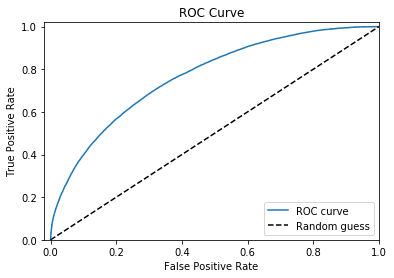

In [659]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

print(roc_auc_score(y, clf.predict_proba(X)[:,1]))

fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:,1])
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [279]:
target_US.corr().to_csv("reg_corr.csv")

In [30]:
target_US=target_US.dropna(how="any",axis=0)

In [55]:
y=target_US["post_return"]
X=target_US[["Market cap","Revision_real","mom","mom_short","30d_vol","EAR"]+list(target_US["Supersector"].unique()[:-2])+\
           list(target_US["Year"].unique()[:-1])+["Q1","Q2","Q3"]+
           list(target_US["Month"].unique()[:-1])+list(target_US["Day"].unique()[:-1])]

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [56]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [34]:
model=LogisticRegression()

In [35]:
model.fit(X_train,y_train)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [36]:
y_pred=model.predict(X_test)

In [48]:
import statsmodels.api as sm
from scipy import stats

In [57]:
sm.OLS

statsmodels.regression.linear_model.OLS

In [58]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()


C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [59]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            post_return   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     28.98
Date:                Mon, 18 Nov 2019   Prob (F-statistic):          8.50e-257
Time:                        16:09:50   Log-Likelihood:                 64669.
No. Observations:               63284   AIC:                        -1.292e+05
Df Residuals:                   63235   BIC:                        -1.288e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.0159      0.003     -5.502      0.000      -0.022      -0.010
Market cap                      0.0003      0.000      1.099      0.272      -0.000       0.001
Revision_real                   0.0129      0.003      4.560      0.000       0.007       0.018
mom                            -0.0006      0.001     -0.561      0.575      -0.002       0.001
mom_short                       0.0338      0.003     10.024      0.000       0.027       0.040
30d_vol                        -0.2139      0.019    -11.025      0.000      -0.252      -0.176
EAR                             0.0290      0.004      6.946      0.000       0.021       0.037
Utilities                      -0.0001      0.002     -0.053      0.958      -0.005       0.004
Oil & Gas                      -0.0141      0.002     -7.047      0.000      -0.018      -0.010
Health Care                     0.0030      0.002      1.624      0.104      -0.001       0.007
Personal & Household Goods     -0.0026      0.002     -1.191      0.234      -0.007       0.002
Retail                          0.0007      0.002      0.337      0.736      -0.003       0.005
Technology                      0.0039      0.002      2.159      0.031       0.000       0.007
Telecommunications              0.0029      0.004      0.821      0.412      -0.004       0.010
Financial Services             -0.0077      0.002     -3.393      0.001      -0.012      -0.003
Travel & Leisure               -0.0027      0.002     -1.216      0.224      -0.007       0.002
Industrial Goods & Services    -0.0015      0.002     -0.850      0.395      -0.005       0.002
Banks                          -0.0028      0.002     -1.276      0.202      -0.007       0.001
Media                          -0.0048      0.003     -1.890      0.059      -0.010       0.000
Automobiles & Parts            -0.0152      0.003     -4.648      0.000      -0.022      -0.009
Insurance                      -0.0016      0.002     -0.693      0.489      -0.006       0.003
Basic Resources                -0.0088      0.003     -3.136      0.002      -0.014      -0.003
Real Estate                    -0.0195      0.005     -3.759      0.000      -0.030      -0.009
Food & Beverage                 0.0042      0.003      1.628      0.103      -0.001       0.009
2007                            0.0131      0.002      7.126      0.000       0.009       0.017
2008                            0.0226      0.002     11.928      0.000       0.019       0.026
2009                            0.0132      0.002      6.776      0.000       0.009       0.017
2010                            0.0248      0.002     12.866      0.000       0.021       0.029
2011                            0.0171      0.002      9.110      0.000       0.013       0.021
2012       

In [51]:
logit.summary()

AttributeError: 'Logit' object has no attribute 'summary'

In [47]:
model.coef_

array([[ 0.0211909 ,  0.14142798, -0.06229548,  0.13866658, -2.25357557,
         0.46565378, -0.08604126, -0.26352093,  0.01700958, -0.06013437,
         0.0079111 ,  0.03671247, -0.05431393, -0.09406793, -0.10078485,
         0.00639657, -0.09570644, -0.20992173, -0.26574956, -0.00675658,
        -0.18790514, -0.38971208,  0.04111621,  0.14449236,  0.46873699,
         0.0921156 ,  0.40418883,  0.3327934 ,  0.22000998,  0.40718866,
         0.24299908,  0.52175547,  0.58197366,  0.04683127,  0.44655742,
        -0.01088748, -0.09383893, -0.0617745 ,  0.02829684,  0.01282056,
         0.01083166, -0.0732644 ,  0.15553475,  0.11203215,  0.15517774,
         0.2270631 , -0.26219424, -0.18463831, -0.27354548, -0.04696397,
         0.05228344]])

In [37]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[5039, 5333],
       [4186, 6537]], dtype=int64)

In [40]:
y_test.mean()

0.5083195069921782

In [41]:
y_pred

array([0., 1., 1., ..., 0., 0., 0.])

In [43]:
X_test["pred"]=y_pred

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
X_test["result"]=y_test

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1457]:
pd.DataFrame(RF_dict_metrics).T.sort_values(1).loc[21]

0         1            2
4 200 5  0.60  0.572483  0.319651   274.411765
2 10  10 0.50  0.523599  0.455241  1831.631579
1 50  5  0.60  0.581987  0.479866   464.550000
2 200 5  0.60  0.588832  0.495741   328.578947
  100 5  0.60  0.589470  0.504813   357.684211
1 200 5  0.60  0.571499  0.509828   461.050000
2 10  5  0.55  0.542777  0.516580  1123.263158
1 200 5  0.50  0.531609  0.518488  1831.700000
3 10  10 0.50  0.524960  0.529844  2028.833333
2 10  5  0.50  0.531451  0.548696  1905.526316
      10 0.60  0.537163  0.586035   854.578947
1 100 5  0.60  0.594237  0.586494   440.450000
         0.50  0.530945  0.592103  1834.900000
2 50  5  0.50  0.538908  0.599018  2066.052632
1 10  10 0.50  0.523164  0.609019  1799.000000
      15 0.50  0.523919  0.613879  1755.050000
3 10  15 0.50  0.526430  0.618791  1831.166667
2 10  15 0.50  0.525221  0.628911  1783.526316
      10 0.55  0.534049  0.634588  1319.684211
3 10  10 0.55  0.530060  0.640532  1469.611111
4 50  5  0.60  0.583481  0.654879   318.411765
2 10  5  0.60  0.579812  0.658471   491.315789
  100 5  0.50  0.542253  0.682386  2069.263158
4 10  15 0.50  0.530817  0.691974  1952.176471
  100 5  0.60  0.609135  0.692043   300.411765
2 200 5  0.55  0.609965  0.695272  1051.631579
1 10  15 0.55  0.525182  0.696407  1493.700000
2 50  5  0.55  0.556470  0.712393  1068.736842
  200 5  0.50  0.545471  0.715630  2095.473684
4 10  10 0.50  0.530316  0.722290  1954.529412
...                 ...       ...          ...
3 100 10 0.60  0.604888  1.101777   509.333333
2 200 15 0.55  0.564807  1.102916  1105.315789
  100 10 0.55  0.574101  1.106868  1129.736842
  50  15 0.60  0.570758  1.118593   631.684211
3 200 15 0.60  0.602103  1.119885   494.666667
      10 0.55  0.577810  1.120329  1209.055556
4 10  10 0.60  0.546938  1.123891   842.823529
2 100 15 0.55  0.558285  1.133131  1155.105263
4 100 15 0.55  0.556941  1.172183  1215.117647
3 200 15 0.55  0.569009  1.181798  1179.611111
1 200 15 0.60  0.589157  1.188770   465.300000
3 100 10 0.55  0.566011  1.190275  1203.166667
  200 10 0.60  0.607792  1.217093   476.166667
  100 15 0.55  0.564305  1.227860  1171.611111
  50  10 0.60  0.578490  1.231728   617.666667
      15 0.55  0.554490  1.250832  1263.000000
  10  5  0.60  0.564002  1.251109   603.888889
  100 15 0.60  0.592476  1.253904   525.444444
4 50  15 0.55  0.550058  1.269710  1285.823529
1 50  10 0.60  0.565415  1.273744   610.000000
3 50  15 0.60  0.589535  1.281964   656.833333
4 50  15 0.60  0.565715  1.298531   645.411765
1 100 10 0.60  0.582689  1.330170   515.350000
  200 15 0.55  0.555076  1.339594  1008.650000
  100 10 0.55  0.555392  1.341935  1087.450000
      15 0.55  0.549160  1.399316  1041.550000
  50  10 0.55  0.549829  1.447868  1186.250000
      15 0.55  0.543234  1.488771  1156.150000
  100 15 0.60  0.570802  1.661778   495.550000
  50  15 0.60  0.557953  2.086226   614.200000

[144 rows x 3 columns]

In [1469]:
(RF_dict[(41,2,50,15,0.6)]<0.5).sum()

hit      9
count    0
dtype: int64

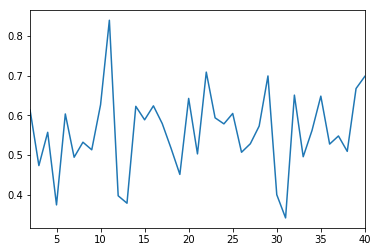

In [1471]:
RF_dict[(41,2,50,15,0.6)]["hit"].plot()

In [1421]:
a,b=rolling_RF_df(X1,y1,41,4,100,10,0.55,True)

In [1422]:
confusion_matrix(b["actual"],b["pred"])

array([[7133, 3226],
       [7165, 4461]], dtype=int64)

In [1423]:
b["year"]=b.apply(lambda x:x.name[1][-4:],axis=1)

In [1424]:
confusion_matrix(b[b["year"]=="2019"]["actual"],b[b["year"]=="2019"]["pred"])

array([[831, 112],
       [670, 237]], dtype=int64)

In [1425]:
b.groupby(b["year"]).apply(sum)

actual    pred  year
year                      
2009   425.0   189.0   inf
2010  1135.0   577.0   inf
2011  1055.0  1099.0   inf
2012   884.0   423.0   inf
2013  1162.0  1020.0   inf
2014  1089.0   627.0   inf
2015  1222.0  1191.0   inf
2016  1319.0  1029.0   inf
2017  1092.0   272.0   inf
2018  1336.0   911.0   inf
2019   907.0   349.0   inf

In [1426]:
b[b["year"]=="2019"].sort_values("pred")

actual  pred  year
EXEL US  02/May/2019 01/Aug/2019 28/Jun/2019       1     0  2019
QD US    20/May/2019 16/Aug/2019 28/Jun/2019       1     0  2019
NTES US  16/May/2019 08/Aug/2019 28/Jun/2019       0     0  2019
EXP US   16/May/2019 31/Jul/2019 28/Jun/2019       0     0  2019
NICE US  16/May/2019 08/Aug/2019 28/Jun/2019       0     0  2019
CSCO US  16/May/2019 15/Aug/2019 28/Jun/2019       0     0  2019
DOX US   15/May/2019 08/Aug/2019 28/Jun/2019       0     0  2019
BABA US  15/May/2019 15/Aug/2019 28/Jun/2019       0     0  2019
PAGS US  15/May/2019 16/Aug/2019 28/Jun/2019       1     0  2019
PPDF US  15/May/2019 NaN         28/Jun/2019       0     0  2019
STE US   14/May/2019 06/Aug/2019 28/Jun/2019       1     0  2019
KRNT US  14/May/2019 07/Aug/2019 28/Jun/2019       0     0  2019
GDS US   14/May/2019 13/Aug/2019 28/Jun/2019       0     0  2019
CYBR US  14/May/2019 07/Aug/2019 28/Jun/2019       1     0  2019
LM US    14/May/2019 02/Aug/2019 28/Jun/2019       1     0  2019
SPWR US  10/May/2019 01/Aug/2019 28/Jun/2019       1     0  2019
NTRA US  10/May/2019 08/Aug/2019 28/Jun/2019       1     0  2019
XNCR US  10/May/2019 07/Aug/2019 28/Jun/2019       0     0  2019
JD US    10/May/2019 13/Aug/2019 28/Jun/2019       0     0  2019
SUPV US  10/May/2019 NaN         28/Jun/2019       1     0  2019
AY US    10/May/2019 07/Aug/2019 28/Jun/2019       1     0  2019
CHRS US  10/May/2019 02/Aug/2019 28/Jun/2019       1     0  2019
EV US    21/May/2019 27/Aug/2019 28/Jun/2019       1     0  2019
GPRO US  10/May/2019 02/Aug/2019 28/Jun/2019       0     0  2019
AZO US   21/May/2019 NaN         28/Jun/2019       1     0  2019
DY US    21/May/2019 28/Aug/2019 28/Jun/2019       1     0  2019
BURL US  30/May/2019 29/Aug/2019 28/Jun/2019       1     0  2019
DG US    30/May/2019 29/Aug/2019 28/Jun/2019       0     0  2019
NXGN US  29/May/2019 25/Jul/2019 28/Jun/2019       0     0  2019
HEI US   29/May/2019 28/Aug/2019 28/Jun/2019       1     0  2019
...                                              ...   ...   ...
SBUX US  26/Jul/2019 NaN         30/Sep/2019       1     1  2019
UHS US   26/Jul/2019 NaN         30/Sep/2019       0     1  2019
FII US   26/Jul/2019 NaN         30/Sep/2019       0     1  2019
OGS US   21/Feb/2019 30/Apr/2019 29/Mar/2019       1     1  2019
TFX US   21/Feb/2019 02/May/2019 29/Mar/2019       1     1  2019
CHE US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
RMD US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
GLPG US  26/Jul/2019 NaN         30/Sep/2019       0     1  2019
SYK US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
MCD US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
TNET US  26/Jul/2019 NaN         30/Sep/2019       0     1  2019
HTH US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
ABG US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
INT US   26/Jul/2019 NaN         30/Sep/2019       1     1  2019
PNW US   22/Feb/2019 01/May/2019 29/Mar/2019       1     1  2019
BAX US   25/Jul/2019 NaN         30/Sep/2019       1     1  2019
AAN US   25/Jul/2019 NaN         30/Sep/2019       1     1  2019
DANOY US 25/Jul/2019 NaN         30/Sep/2019       1     1  2019
AZN US   25/Jul/2019 NaN         30/Sep/2019       1     1  2019
ICLR US  25/Jul/2019 NaN         30/Sep/2019       1     1  2019
PEG US   27/Feb/2019 02/May/2019 29/Mar/2019       0     1  2019
INTU US  22/Feb/2019 24/May/2019 29/Mar/2019       1     1  2019
HSY US   25/Jul/2019 NaN         30/Sep/2019       1     1  2019
TPX US   25/Jul/2019 NaN         30/Sep/2019       0     1  2019
IART US  21/Feb/2019 24/Apr/2019 29/Mar/2019       1     1  2019
A US     21/Feb/2019 15/May/2019 29/Mar/2019       1     1  2019
WM US    25/Jul/2019 NaN         30/Sep/2019       1     1  2019
KOF US   26/Jul/2019 NaN         30/Sep/2019       0     1  2019
VMC US   25/Jul/2019 NaN         30/Sep/2019       1     1  2019
BBBY US  10/Jan/2019 11/Apr/2019 29/Mar/2019       0     1  2019

[1850 rows x 3 